In [1]:
import random
import numpy as np
import torch

SEED = 42 # Or any integer you prefer
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Potentially add for full reproducibility, though might impact performance slightly
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

In [2]:
# Cell 1: Import Libraries

import torch
import torch.nn as nn # Neural network modules
import torchvision
import torchvision.transforms as transforms # Common image transformations
import torchvision.models as models # Pre-trained models
from torch.utils.data import DataLoader, Dataset # Utilities for dataset handling and loading
from torchvision.datasets import ImageFolder # For loading image datasets from a folder structure

import numpy as np # For numerical operations
import json # For loading the JSON label file
import os # For operating system dependent functionality like path handling
from PIL import Image # Python Imaging Library (Pillow) for image manipulation

# For potential plotting later, not strictly required for Task 1 evaluation
import matplotlib.pyplot as plt

# Print library versions for an an_INFOrmational check
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

PyTorch Version: 2.7.0+cu118
Torchvision Version: 0.22.0+cu118


In [3]:
# Cell 2: Configuration and Paths

# --- Configuration ---
# IMPORTANT: Adjust these paths if your files are located elsewhere or named differently.

DATASET_ROOT_PATH = "./TestDataSet/TestDataSet"  # CORRECTED path to the directory containing n0xxxxxxx folders
JSON_LABEL_FILE = "./TestDataSet/TestDataSet/labels_list.json" # Path to your JSON file
# Device configuration: Use CUDA (GPU) if available, otherwise fallback to CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Batch size for DataLoader (how many images to process at once)
BATCH_SIZE = 32

# ImageNet normalization statistics (provided in the project document [Source 17])
MEAN_NORMS = np.array([0.485, 0.456, 0.406])
STD_NORMS = np.array([0.229, 0.224, 0.225])

Using device: cuda


In [4]:
# Cell 3: Define Image Preprocessing Transforms

# Preprocessing transforms are crucial for preparing images for the model.
# ResNet models, including ResNet-34, typically expect 224x224 input images.
# These steps ensure consistency and proper formatting.
plain_transforms = transforms.Compose([
    transforms.Resize(256),             # 1. Resize the smaller edge of the image to 256 pixels.
    transforms.CenterCrop(224),         # 2. Crop the center 224x224 square from the resized image.
    transforms.ToTensor(),              # 3. Convert the PIL Image (or numpy.ndarray) to a PyTorch tensor.
                                        #    This also scales pixel values from the [0, 255] range to [0.0, 1.0].
    transforms.Normalize(mean=MEAN_NORMS, std=STD_NORMS) # 4. Normalize the tensor image with ImageNet's mean and std.
])

print("Image preprocessing transforms defined.")

Image preprocessing transforms defined.


In [5]:
# Cell 4: Load Dataset and DataLoader

# Attempt to load the dataset using ImageFolder
# ImageFolder expects a directory structure like: root_path/class_name/image.jpg
try:
    test_dataset = ImageFolder(root=DATASET_ROOT_PATH, transform=plain_transforms)
    print(f"Dataset loaded successfully from '{DATASET_ROOT_PATH}'.")
    print(f"Number of images found: {len(test_dataset)}")
    print(f"Number of classes (subfolders) found: {len(test_dataset.classes)}")
    
    # Uncomment these lines if you want to inspect the classes found by ImageFolder:
    # print(f"Class names (folder names automatically detected): {test_dataset.classes}")
    # print(f"Mapping from class name to internal index: {test_dataset.class_to_idx}")

except FileNotFoundError:
    print(f"ERROR: Dataset directory '{DATASET_ROOT_PATH}' not found. Please check the path in Cell 2.")
except Exception as e:
    print(f"ERROR: Could not load dataset from '{DATASET_ROOT_PATH}'.")
    print(f"Please ensure the directory exists and is structured with class subdirectories (e.g., TestDataSet/class_A/image.jpg).")
    print(f"Detailed error: {e}")

# Create DataLoader if the dataset was loaded successfully
# shuffle=False is important for evaluation to maintain consistent order for debugging.
if 'test_dataset' in locals() and test_dataset: # Check if test_dataset exists and is not empty
    print(f"First 5 class folders found by ImageFolder: {test_dataset.classes[:5]}")
    print(f"Last 5 class folders found by ImageFolder: {test_dataset.classes[-5:]}")
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False, # Do not shuffle for evaluation/testing
        num_workers=2  # Number of subprocesses to use for data loading (can speed it up if > 0)
    )
    print(f"DataLoader created with batch size {BATCH_SIZE}.")
else:
    print("DataLoader not created because the dataset failed to load or was empty.")

Dataset loaded successfully from './TestDataSet/TestDataSet'.
Number of images found: 500
Number of classes (subfolders) found: 100
First 5 class folders found by ImageFolder: ['n02672831', 'n02676566', 'n02687172', 'n02690373', 'n02692877']
Last 5 class folders found by ImageFolder: ['n03026506', 'n03028079', 'n03032252', 'n03041632', 'n03042490']
DataLoader created with batch size 32.


In [6]:
# Cell 5: Load Label Mapping from JSON and Prepare for Validation
# REVISED based on synset folder names and labels_list.json, using a sorted order matching hypothesis.



try:
    # Ensure 'models' is imported (it should be from Cell 1: import torchvision.models as models)
    # This check is just a safeguard; Cell 1 should have already imported 'models'.
    if 'models' not in globals() and 'models' not in locals():
        import torchvision.models as models
        

    temp_model_weights = models.ResNet34_Weights.IMAGENET1K_V1
    MODEL_1000_CLASS_NAMES = temp_model_weights.meta["categories"] 
    print(f"Successfully defined MODEL_1000_CLASS_NAMES with {len(MODEL_1000_CLASS_NAMES)} entries.")
    # print(f"  First few class names from MODEL_1000_CLASS_NAMES: {MODEL_1000_CLASS_NAMES[:5]}") 
except Exception as e:
    print(f"ERROR in Cell 5 when trying to define MODEL_1000_CLASS_NAMES: {e}")
    MODEL_1000_CLASS_NAMES = [] 

    

folder_name_to_resnet_idx = {} 
json_parsed_target_indices = [] 

if 'test_dataset' in locals() and test_dataset and len(test_dataset.classes) > 0:
    try:
        # Load and parse the JSON file to get the target ResNet indices
        with open(JSON_LABEL_FILE, 'r') as f:
            json_data_list = json.load(f) # List of strings like "401: accordion"
        print(f"Successfully loaded JSON data from '{JSON_LABEL_FILE}'. It contains {len(json_data_list)} entries.")

        for item_string in json_data_list:
            try:
                parts = item_string.split(': ', 1)
                if len(parts) == 2:
                    idx_str = parts[0]
                    json_parsed_target_indices.append(int(idx_str))
                else:
                    print(f"  Warning: Could not parse JSON item string: '{item_string}'. Expected format 'index: name'. Skipping.")
            except ValueError:
                print(f"  Warning: Could not convert index to int for JSON item string: '{item_string}'. Skipping.")
        
        # Ensure the parsed indices from JSON are sorted (they likely are, but good practice)
        json_parsed_target_indices.sort()
        num_json_entries = len(json_parsed_target_indices)
        print(f"Successfully parsed {num_json_entries} target ResNet indices from JSON.")
        if num_json_entries > 0:
            print(f"  First few parsed target indices: {json_parsed_target_indices[:5]}")
            print(f"  Last few parsed target indices: {json_parsed_target_indices[-5:] if num_json_entries > 5 else json_parsed_target_indices}")


        # Get the list of folder names (synsets) found by ImageFolder and sort them alphabetically
        # This is crucial for the "sorted order matching" hypothesis
        sorted_synset_folder_names = sorted(test_dataset.classes)
        num_dataset_classes = len(sorted_synset_folder_names)
        print(f"Found {num_dataset_classes} class folders (synsets) in the dataset (path: '{DATASET_ROOT_PATH}').")
        if num_dataset_classes > 0:
            print(f"  First few alphabetically sorted synset folder names: {sorted_synset_folder_names[:5]}")
            print(f"  Last few alphabetically sorted synset folder names: {sorted_synset_folder_names[-5:] if num_dataset_classes > 5 else sorted_synset_folder_names}")


        # --- Hypothesis: Match sorted synset folder names to sorted JSON target indices ---
        if num_dataset_classes == num_json_entries and num_dataset_classes > 0 : # Check if counts match
            for i in range(num_dataset_classes):
                synset_folder = sorted_synset_folder_names[i]
                target_resnet_idx = json_parsed_target_indices[i]
                folder_name_to_resnet_idx[synset_folder] = target_resnet_idx
            
            print(f"\nSuccessfully created mapping for {len(folder_name_to_resnet_idx)} classes "
                  "by matching alphabetically sorted dataset folder names (synsets) "
                  "to the target ResNet indices sorted from the JSON file.")
            if folder_name_to_resnet_idx:
                 # Print a few example mapping entries
                 example_items = list(folder_name_to_resnet_idx.items())
                 print(f"  Example mapping entries (first 3 if available): {example_items[:3]}")
                 if len(example_items) > 3:
                    print(f"  Example mapping entries (last 3 if available): {example_items[-3:]}")

        else:
            print("\nERROR: The number of class folders found in the dataset "
                  f"({num_dataset_classes}) does not match the number of entries "
                  f"parsed from the JSON file ({num_json_entries}).")
            print("Cannot perform reliable mapping based on sorted order. "
                  "Please ensure your 'TestDataSet' contains the correct number of class folders (expected: 100, matching JSON entries) "
                  "and that 'DATASET_ROOT_PATH' in Cell 2 points to the directory directly containing these class folders.")
            folder_name_to_resnet_idx = {} # Clear map if counts don't match

    except FileNotFoundError:
        print(f"ERROR: JSON label file '{JSON_LABEL_FILE}' not found. Please ensure the path in Cell 2 is correct.")
    except json.JSONDecodeError:
        print(f"ERROR: Could not decode JSON from '{JSON_LABEL_FILE}'. Please ensure it's a valid JSON file (a list of strings).")
    except Exception as e:
        print(f"An unexpected error occurred in Cell 5 while processing labels: {e}")
        folder_name_to_resnet_idx = {} # Ensure map is empty on other errors
else:
    print("Cell 5 skipped: 'test_dataset' was not loaded successfully or no classes were found in Cell 4.")

Successfully defined MODEL_1000_CLASS_NAMES with 1000 entries.
Successfully loaded JSON data from './TestDataSet/TestDataSet/labels_list.json'. It contains 100 entries.
Successfully parsed 100 target ResNet indices from JSON.
  First few parsed target indices: [401, 402, 403, 404, 405]
  Last few parsed target indices: [496, 497, 498, 499, 500]
Found 100 class folders (synsets) in the dataset (path: './TestDataSet/TestDataSet').
  First few alphabetically sorted synset folder names: ['n02672831', 'n02676566', 'n02687172', 'n02690373', 'n02692877']
  Last few alphabetically sorted synset folder names: ['n03026506', 'n03028079', 'n03032252', 'n03041632', 'n03042490']

Successfully created mapping for 100 classes by matching alphabetically sorted dataset folder names (synsets) to the target ResNet indices sorted from the JSON file.
  Example mapping entries (first 3 if available): [('n02672831', 401), ('n02676566', 402), ('n02687172', 403)]
  Example mapping entries (last 3 if available):

In [7]:
# Cell 6: Load Pre-trained ResNet-34 Model

# Load the ResNet-34 model pre-trained on ImageNet-1K, as specified in [Source 14].
# weights='IMAGENET1K_V1' ensures we get weights trained on the ImageNet-1K dataset.
try:
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.to(DEVICE)  # Move the model to the configured device (GPU or CPU)
    
    # Set the model to evaluation mode. This is CRUCIAL.
    # It affects layers like Dropout and BatchNorm, ensuring deterministic output.
    model.eval()
    
    print("ResNet-34 model loaded successfully, moved to device, and set to evaluation mode.")
except Exception as e:
    print(f"Error loading or setting up the ResNet-34 model: {e}")
    model = None # Ensure model is None if loading failed

ResNet-34 model loaded successfully, moved to device, and set to evaluation mode.


In [8]:
# Cell 7: Evaluation Loop for Top-1 and Top-5 Accuracy

# Proceed only if all necessary components (dataloader, model, and label mapping) are available.
if ('test_dataloader' in locals() and test_dataloader and
    'model' in locals() and model and
    'folder_name_to_resnet_idx' in locals() and folder_name_to_resnet_idx):
    
    print("Starting model evaluation on the test dataset...")
    
    top1_correct_predictions = 0
    top5_correct_predictions = 0
    total_samples_for_evaluation = 0 

    # Disable gradient calculations during evaluation for efficiency and to prevent accidental training.
    with torch.no_grad():
        for batch_idx, (images_batch, local_labels_batch_idx) in enumerate(test_dataloader):
            images_batch = images_batch.to(DEVICE)
            # local_labels_batch_idx contains local indices (e.g., 0-99) from ImageFolder.

            # Get model predictions (outputs are logits for the 1000 ImageNet classes)
            outputs_batch = model(images_batch) # Shape: (BATCH_SIZE, 1000)

            # Get the top 5 predicted class indices (0-999 for ResNet) and their scores (logits)
            # torch.topk returns (values, indices)
            _, top5_predicted_global_indices_batch = torch.topk(outputs_batch, k=5, dim=1)
            # top5_predicted_global_indices_batch shape: (BATCH_SIZE, 5)

            # Convert local ground truth labels from ImageFolder to ResNet's global 0-999 indices
            # using the `folder_name_to_resnet_idx` mapping.
            current_batch_true_global_indices = []
            for local_idx_item in local_labels_batch_idx:
                folder_name = test_dataset.classes[local_idx_item.item()]
                if folder_name in folder_name_to_resnet_idx:
                    current_batch_true_global_indices.append(folder_name_to_resnet_idx[folder_name])
                else:
                    # This case should be rare if JSON mapping was successful for all classes.
                    # Append a placeholder (e.g., -1) for unmappable ground truth labels.
                    # These samples will be skipped in accuracy calculation.
                    current_batch_true_global_indices.append(-1) 
            
            current_batch_true_global_indices_tensor = torch.tensor(current_batch_true_global_indices, device=DEVICE)

            # Compare predictions with true labels for each sample in the batch
            for i in range(images_batch.size(0)): # Iterate over samples in the current batch
                true_global_idx_sample = current_batch_true_global_indices_tensor[i].item()
                
                # Skip sample if its ground truth label could not be mapped to ResNet's 1000 classes
                if true_global_idx_sample == -1:
                    continue 
                
                total_samples_for_evaluation += 1
                
                # Top-1 Accuracy Check: Is the highest-scoring prediction correct?
                predicted_top1_global_idx_sample = top5_predicted_global_indices_batch[i, 0].item()
                if predicted_top1_global_idx_sample == true_global_idx_sample:
                    top1_correct_predictions += 1
                
                # Top-5 Accuracy Check: Is the true label among the top 5 predictions?
                if true_global_idx_sample in top5_predicted_global_indices_batch[i, :].tolist():
                    top5_correct_predictions += 1
            
            if (batch_idx + 1) % 5 == 0: # Print progress, e.g., every 5 batches
                print(f"  Processed batch {batch_idx + 1}/{len(test_dataloader)}...")

    # Calculate and print final accuracies
    if total_samples_for_evaluation > 0:
        top1_accuracy = (top1_correct_predictions / total_samples_for_evaluation) * 100
        top5_accuracy = (top5_correct_predictions / total_samples_for_evaluation) * 100
        
        print("\n--- Evaluation Complete ---")
        print(f"Total samples effectively evaluated (with valid GT mapping): {total_samples_for_evaluation}")
        print(f"Top-1 Accuracy: {top1_correct_predictions}/{total_samples_for_evaluation} = {top1_accuracy:.2f}%")
        print(f"Top-5 Accuracy: {top5_correct_predictions}/{total_samples_for_evaluation} = {top5_accuracy:.2f}%")
    else:
        print("\nEvaluation could not be performed or no samples were effectively evaluated.")
        print("This might be due to issues with dataset loading, an empty dataset, or problems with the JSON label mapping (Cell 5).")
        print("Please review previous cell outputs for errors or warnings.")
else:
    print("\nSkipping evaluation loop due to errors or missing components from previous cells.")
    print("Please ensure dataset, model, and label mapping ('folder_name_to_resnet_idx') were all loaded/created successfully.")

Starting model evaluation on the test dataset...
  Processed batch 5/16...
  Processed batch 10/16...
  Processed batch 15/16...

--- Evaluation Complete ---
Total samples effectively evaluated (with valid GT mapping): 500
Top-1 Accuracy: 353/500 = 70.60%
Top-5 Accuracy: 466/500 = 93.20%


In [9]:
# Cell 8: Task 1 Complete - Summary

print("\n--- Task 1 Summary ---")
print("If all previous cells ran without critical errors, you have now (hopefully):")
print("1. Successfully set up your Python environment with 'uv' and installed necessary libraries.")
print("2. Loaded and preprocessed the 'TestDataSet', ensuring all images are resized and normalized correctly.")
print("3. Loaded the pre-trained ResNet-34 model and set it to evaluation mode.")
print("4. Crucially, established a mapping from your dataset's class labels (derived from folder names) to the ")
print("   ResNet-34 model's 1000 output class indices, using your provided JSON file.")
print("5. Evaluated the model's Top-1 and Top-5 accuracy on your preprocessed test dataset.")
print("\nThese baseline accuracy numbers are essential for the subsequent tasks where you will be performing adversarial attacks.")
print("Make sure to record these numbers accurately in your project report as required by [Source 20].")
print("\nNext steps would typically involve Task 2: Implementing the Fast Gradient Sign Method (FGSM) attack.")


--- Task 1 Summary ---
If all previous cells ran without critical errors, you have now (hopefully):
1. Successfully set up your Python environment with 'uv' and installed necessary libraries.
2. Loaded and preprocessed the 'TestDataSet', ensuring all images are resized and normalized correctly.
3. Loaded the pre-trained ResNet-34 model and set it to evaluation mode.
4. Crucially, established a mapping from your dataset's class labels (derived from folder names) to the 
   ResNet-34 model's 1000 output class indices, using your provided JSON file.
5. Evaluated the model's Top-1 and Top-5 accuracy on your preprocessed test dataset.

These baseline accuracy numbers are essential for the subsequent tasks where you will be performing adversarial attacks.
Make sure to record these numbers accurately in your project report as required by [Source 20].

Next steps would typically involve Task 2: Implementing the Fast Gradient Sign Method (FGSM) attack.


In [10]:
# This function assumes the dataloader yields (images, true_GLOBAL_resnet_indices)
# For Task 1, you'd need to ensure true_GLOBAL_resnet_indices are passed correctly.
# The loop in Cell 7 already does the mapping from local to global, so you can adapt that.

def evaluate_model_on_dataset(model_to_evaluate, dataloader, device):
    model_to_evaluate.eval() # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total_samples = 0

    # If using the original test_dataloader from Task 1, you need dataset.classes and 
    # folder_name_to_resnet_idx to convert local labels to global inside this function,
    # OR ensure the dataloader passed here already provides global labels.
    # Let's assume for now this function will be used with dataloaders that
    # directly provide (images, true_GLOBAL_resnet_indices_batch)

    with torch.no_grad():
        for images_batch, true_global_indices_batch in dataloader: # EXPECTS GLOBAL INDICES
            images_batch = images_batch.to(device)
            true_global_indices_batch = true_global_indices_batch.to(device)

            outputs_batch = model_to_evaluate(images_batch)
            _, top5_predicted_global_indices_batch = torch.topk(outputs_batch, k=5, dim=1)

            for i in range(images_batch.size(0)):
                true_global_idx_sample = true_global_indices_batch[i].item()
                total_samples += 1

                if top5_predicted_global_indices_batch[i, 0].item() == true_global_idx_sample:
                    top1_correct += 1

                if true_global_idx_sample in top5_predicted_global_indices_batch[i, :].tolist():
                    top5_correct += 1

    if total_samples == 0:
        print("Warning: No samples were evaluated by 'evaluate_model_on_dataset'.")
        return 0.0, 0.0

    top1_accuracy = (top1_correct / total_samples) * 100
    top5_accuracy = (top5_correct / total_samples) * 100

    print(f"Evaluation on {total_samples} samples:")
    print(f"  Top-1 Accuracy: {top1_correct}/{total_samples} = {top1_accuracy:.2f}%")
    print(f"  Top-5 Accuracy: {top5_correct}/{total_samples} = {top5_accuracy:.2f}%")
    return top1_accuracy, top5_accuracy

# You can test it with your Task 1 setup if you adapt how labels are fed or handled.
# For now, your Cell 7 logic works fine for Task 1. This function is more for future use
# with adversarial datasets where you explicitly store (image, true_global_label).

In [11]:
# Cell 9: Define FGSM Attack Function

import torch.nn.functional as F # For functional operations if needed, though CrossEntropyLoss is a module

# Define the FGSM attack function
def fgsm_attack(model, loss_function, images_batch, true_global_labels_batch, epsilon, device, data_mean, data_std):
    """
    Generates adversarial images using the Fast Gradient Sign Method (FGSM).

    Args:
        model: The model to attack.
        loss_function: The loss function (e.g., nn.CrossEntropyLoss).
        images_batch: A batch of input images (normalized tensors, NCHW format).
        true_global_labels_batch: True labels for the images (global ResNet indices).
        epsilon: The perturbation magnitude (for normalized image space).
        device: The device to perform computations on (e.g., 'cuda' or 'cpu').
        data_mean: Dataset mean for each channel (used for clipping).
        data_std: Dataset std for each channel (used for clipping).

    Returns:
        adv_images_batch: Batch of adversarial images (normalized tensors).
    """
    # Ensure the input images require gradients
    images_batch_clone = images_batch.clone().detach().requires_grad_(True)
    true_global_labels_batch = true_global_labels_batch.to(device)

    # Forward pass
    model.zero_grad() # Clear any existing gradients
    outputs = model(images_batch_clone)
    loss = loss_function(outputs, true_global_labels_batch)

    # Backward pass to get gradients of loss w.r.t. input images
    loss.backward()

    # Collect the gradients
    gradients = images_batch_clone.grad.data

    # Get the sign of the gradients
    sign_of_gradients = gradients.sign()

    # Create the adversarial images by adding the perturbation
    # The perturbation is epsilon * sign_of_gradients
    adv_images_batch = images_batch_clone + epsilon * sign_of_gradients
    
    # Clip the adversarial images to maintain valid data range for *normalized* images.
    # This is crucial: images were originally 0-1, then normalized.
    # So, for each channel c, valid normalized range is [(0-mean[c])/std[c], (1-mean[c])/std[c]]
    
    # Reshape mean and std for broadcasting with image tensor (NCHW)
    # Mean and std are likely (3,) numpy arrays or tensors. Need (1, 3, 1, 1) for NCHW.
    if isinstance(data_mean, np.ndarray):
        data_mean_tensor = torch.tensor(data_mean, dtype=torch.float32, device=device).view(1, -1, 1, 1)
        data_std_tensor = torch.tensor(data_std, dtype=torch.float32, device=device).view(1, -1, 1, 1)
    else: # Assuming they are already tensors
        data_mean_tensor = data_mean.view(1, -1, 1, 1).to(device)
        data_std_tensor = data_std.view(1, -1, 1, 1).to(device)

    # Calculate min and max valid values in the normalized space
    min_vals_normalized = (0.0 - data_mean_tensor) / data_std_tensor
    max_vals_normalized = (1.0 - data_mean_tensor) / data_std_tensor
    
    # Element-wise clipping
    adv_images_batch_clipped = torch.max(torch.min(adv_images_batch, max_vals_normalized), min_vals_normalized)
    
    # Detach the adversarial images from the computation graph
    return adv_images_batch_clipped.detach()

# Define the loss function to be used for generating adversarial examples
criterion = nn.CrossEntropyLoss()
EPSILON_TASK2 = 0.02 # As specified in [Source 23]

print("FGSM attack function defined.")
print(f"Loss function for attack: CrossEntropyLoss")
print(f"Epsilon for Task 2: {EPSILON_TASK2}")

FGSM attack function defined.
Loss function for attack: CrossEntropyLoss
Epsilon for Task 2: 0.02


In [12]:
# Cell 10: Generate Adversarial Test Set 1

# This cell will iterate through the original test_dataloader (from Task 1),
# generate adversarial examples using FGSM for each batch,
# and collect them to form "Adversarial Test Set 1".

# Ensure all necessary variables from Task 1 are available:
# model, test_dataloader, test_dataset.classes, folder_name_to_resnet_idx, DEVICE,
# MEAN_NORMS, STD_NORMS, criterion, EPSILON_TASK2

if not all(k in globals() or k in locals() for k in ['model', 'test_dataloader', 'test_dataset', 'folder_name_to_resnet_idx', 'DEVICE', 'MEAN_NORMS', 'STD_NORMS', 'criterion', 'EPSILON_TASK2']):
    print("ERROR: Not all required variables from previous cells are available. Please re-run previous cells.")
else:
    print(f"Starting generation of 'Adversarial Test Set 1' using FGSM with epsilon={EPSILON_TASK2}...")
    
    adversarial_images_list_t2 = []  # To store adversarial image tensors
    original_true_labels_list_t2 = [] # To store corresponding true global labels

    model.eval() # Ensure model is in evaluation mode for attack generation consistency

    processed_batches = 0
    for original_images_batch, local_labels_idx_batch in test_dataloader:
        original_images_batch = original_images_batch.to(DEVICE)
        
        # Convert local ImageFolder labels to the global ResNet indices (0-999)
        # This is needed as input to the fgsm_attack function (for loss calculation)
        batch_true_global_indices_list = []
        for local_idx in local_labels_idx_batch:
            folder_name = test_dataset.classes[local_idx.item()]
            if folder_name in folder_name_to_resnet_idx: # Use the mapping from Cell 5
                batch_true_global_indices_list.append(folder_name_to_resnet_idx[folder_name])
            else:
                # This should ideally not happen if mapping in Cell 5 was complete for all classes
                print(f"  Warning: Could not find global index for folder '{folder_name}' during FGSM. Skipping its label (this image won't be used effectively).")
                batch_true_global_indices_list.append(-1) # Placeholder, handle later if necessary
        
        true_global_labels_batch_tensor = torch.tensor(batch_true_global_indices_list, dtype=torch.long, device=DEVICE)

        # Filter out samples where label mapping failed, if any (though ideally all map)
        valid_indices_for_attack = (true_global_labels_batch_tensor != -1)
        if not torch.all(valid_indices_for_attack): # If there are any invalid labels
            print(f"  Note: Some samples in current batch had unmappable labels and might be skipped or handled differently by FGSM if loss fails.")
            # Depending on CrossEntropyLoss behavior, might need to filter images_batch too if some labels are -1
            # For simplicity here, we assume most/all labels are valid. If CrossEntropy fails with -1, filtering is needed.
            # CrossEntropyLoss usually expects non-negative labels.
            # A robust way: filter images_batch and true_global_labels_batch_tensor to only include valid_indices_for_attack

        # Generate adversarial images for the current batch
        adv_batch = fgsm_attack(
            model, 
            criterion, 
            original_images_batch, # Pass only valid images if filtering implemented
            true_global_labels_batch_tensor, # Pass only valid labels if filtering implemented
            EPSILON_TASK2, 
            DEVICE,
            MEAN_NORMS, # Pass numpy array or tensor
            STD_NORMS   # Pass numpy array or tensor
        )
        
        # Store the generated adversarial images (on CPU) and their original true labels
        adversarial_images_list_t2.append(adv_batch.cpu())
        original_true_labels_list_t2.append(true_global_labels_batch_tensor.cpu()) # Store the global labels

        processed_batches += 1
        if processed_batches % 5 == 0:
            print(f"  FGSM: Processed batch {processed_batches}/{len(test_dataloader)}...")

    # Concatenate all batches to form the full adversarial dataset tensors
    if adversarial_images_list_t2:
        adv_images_full_tensor_t2 = torch.cat(adversarial_images_list_t2, dim=0)
        original_labels_full_tensor_t2 = torch.cat(original_true_labels_list_t2, dim=0)
        
        # Create a TensorDataset for "Adversarial Test Set 1"
        # This dataset contains (adversarial_image, original_true_GLOBAL_label)
        adv_dataset_t2 = torch.utils.data.TensorDataset(adv_images_full_tensor_t2, original_labels_full_tensor_t2)
        
        # Create a DataLoader for the adversarial dataset
        adv_dataloader_t2 = DataLoader(adv_dataset_t2, batch_size=BATCH_SIZE, shuffle=False)
        
        print(f"\n'Adversarial Test Set 1' created with {len(adv_dataset_t2)} samples.")
        print("It is now available as 'adv_dataloader_t2'.")
        print(f"  Shape of adversarial images tensor: {adv_images_full_tensor_t2.shape}")
        print(f"  Shape of original labels tensor: {original_labels_full_tensor_t2.shape}")
    else:
        print("ERROR: No adversarial examples were generated. Check for errors in the loop.")

Starting generation of 'Adversarial Test Set 1' using FGSM with epsilon=0.02...
  FGSM: Processed batch 5/16...
  FGSM: Processed batch 10/16...
  FGSM: Processed batch 15/16...

'Adversarial Test Set 1' created with 500 samples.
It is now available as 'adv_dataloader_t2'.
  Shape of adversarial images tensor: torch.Size([500, 3, 224, 224])
  Shape of original labels tensor: torch.Size([500])


In [13]:
torch.save(adv_images_full_tensor_t2, 'adversarial_test_set_1_images.pt')
torch.save(original_labels_full_tensor_t2, 'adversarial_test_set_1_labels.pt') 

In [15]:
# Cell 11: Verify L-infinity Distance and Prepare for Visualization (FURTHER REVISED - unnormalize_tensor scope fixed)

# --- Part 1: Re-collect original images (Done ONCE at the top) ---
print("Attempting to re-collect original images for comparison...")
original_images_for_comparison_list = []
# It's good practice to ensure test_dataloader exists before iterating
if 'test_dataloader' in locals() and test_dataloader:
    for orig_imgs_batch, _ in test_dataloader: # Iterate through original dataloader again
        original_images_for_comparison_list.append(orig_imgs_batch)
else:
    print("Error: 'test_dataloader' is not available. Cannot recollect original images.")

original_images_full_tensor = None # Initialize to None
if original_images_for_comparison_list:
    try:
        original_images_full_tensor = torch.cat(original_images_for_comparison_list, dim=0)
        print(f"Successfully re-collected 'original_images_full_tensor' with shape: {original_images_full_tensor.shape}")
    except Exception as e:
        print(f"Error concatenating original images: {e}")
        original_images_full_tensor = None # Ensure it's None on error
else:
    print("Warning: 'original_images_for_comparison_list' was empty. 'original_images_full_tensor' not created.")


# --- Part 2: Define Helper function to unnormalize images for display (MOVED TO TOP LEVEL OF CELL) ---
# This function will now be defined when Cell 11 is run,
# provided MEAN_NORMS and STD_NORMS (from Cell 2) are available when it's called from Cell 12.

def unnormalize_tensor(tensor_img, mean_values, std_values): # Accepts mean and std as arguments
    # tensor_img: a single image tensor (C, H, W) or a batch (N, C, H, W)
    # mean_values, std_values: numpy arrays or PyTorch tensors of shape (C,)
    
    _mean = mean_values
    _std = std_values
    
    # Ensure they are tensors for operations
    if isinstance(_mean, np.ndarray):
        _mean = torch.tensor(_mean, dtype=tensor_img.dtype, device=tensor_img.device)
    if isinstance(_std, np.ndarray):
        _std = torch.tensor(_std, dtype=tensor_img.dtype, device=tensor_img.device)
    
    # Reshape for broadcasting
    if tensor_img.ndim == 3: # Single image C, H, W
        _mean = _mean.view(-1, 1, 1)
        _std = _std.view(-1, 1, 1)
    elif tensor_img.ndim == 4: # Batch N, C, H, W
        _mean = _mean.view(1, -1, 1, 1)
        _std = _std.view(1, -1, 1, 1)
    else:
        # This case should ideally not be hit with image data
        print(f"Warning: unnormalize_tensor received tensor with unexpected ndim: {tensor_img.ndim}. Returning original.")
        return tensor_img # Return original tensor if shape is not recognized
            
    unnormalized_img = tensor_img.mul(_std).add(_mean) # unnormalize: (tensor * std) + mean
    unnormalized_img = torch.clamp(unnormalized_img, 0.0, 1.0) # Clip to [0, 1] range
    return unnormalized_img




# --- Part 3: L-infinity check (Now after unnormalize_tensor is defined) ---
# Check if ALL necessary tensors for L-infinity check are available BEFORE proceeding
if ('adv_images_full_tensor_t2' in locals() and adv_images_full_tensor_t2 is not None and
    'original_images_full_tensor' in locals() and original_images_full_tensor is not None):

    print("\nVerifying L-infinity distance for a few examples...")
    num_examples_to_check = 5
    
    if len(original_images_full_tensor) == len(adv_images_full_tensor_t2):
        for i in range(min(num_examples_to_check, len(adv_images_full_tensor_t2))):
            original_img_norm = original_images_full_tensor[i]
            adversarial_img_norm = adv_images_full_tensor_t2[i]
            
            perturbation = adversarial_img_norm - original_img_norm
            l_infinity_dist = torch.max(torch.abs(perturbation)).item()
            
            print(f"  Example {i+1}:")
            print(f"    L-infinity distance between original and adversarial (normalized space): {l_infinity_dist:.6f}")
            if l_infinity_dist - EPSILON_TASK2 > 1e-5: # Check with a small tolerance
                 print(f"    WARNING: L_infinity distance {l_infinity_dist:.6f} is greater than epsilon {EPSILON_TASK2:.6f} for example {i+1}!")
    else:
        print(f"Warning: Number of original images ({len(original_images_full_tensor) if original_images_full_tensor is not None else 'None'}) "
              f"does not match number of adversarial images ({len(adv_images_full_tensor_t2) if adv_images_full_tensor_t2 is not None else 'None'}). "
              "Cannot perform L-infinity verification accurately.")
else:
    print("\nSkipping L-infinity check due to missing prerequisite tensors "
          "('adv_images_full_tensor_t2' or 'original_images_full_tensor' was not properly created/available).")

Attempting to re-collect original images for comparison...
Successfully re-collected 'original_images_full_tensor' with shape: torch.Size([500, 3, 224, 224])

Verifying L-infinity distance for a few examples...
  Example 1:
    L-infinity distance between original and adversarial (normalized space): 0.020000
  Example 2:
    L-infinity distance between original and adversarial (normalized space): 0.020000
  Example 3:
    L-infinity distance between original and adversarial (normalized space): 0.020000
  Example 4:
    L-infinity distance between original and adversarial (normalized space): 0.020000
  Example 5:
    L-infinity distance between original and adversarial (normalized space): 0.020000


Visualizing 3 adversarial examples...


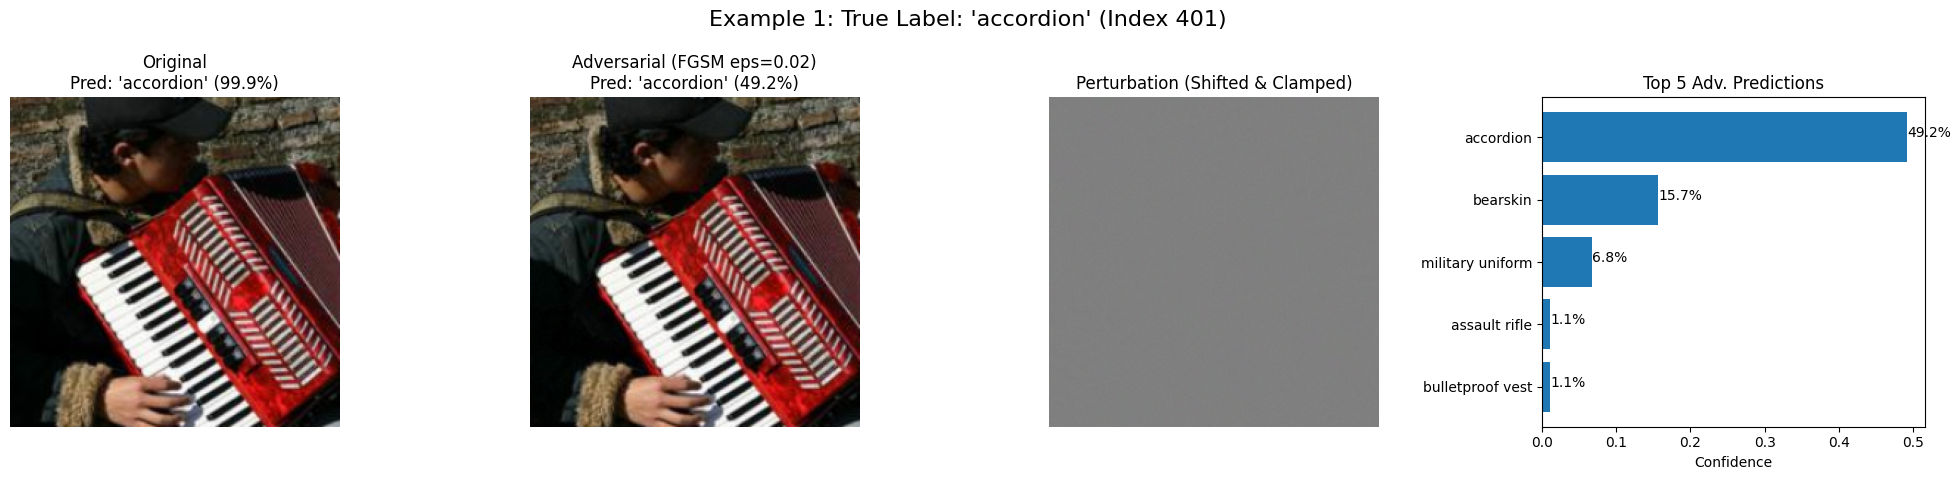

  Attack FAILED for Example 1: Adversarial prediction is still correct.


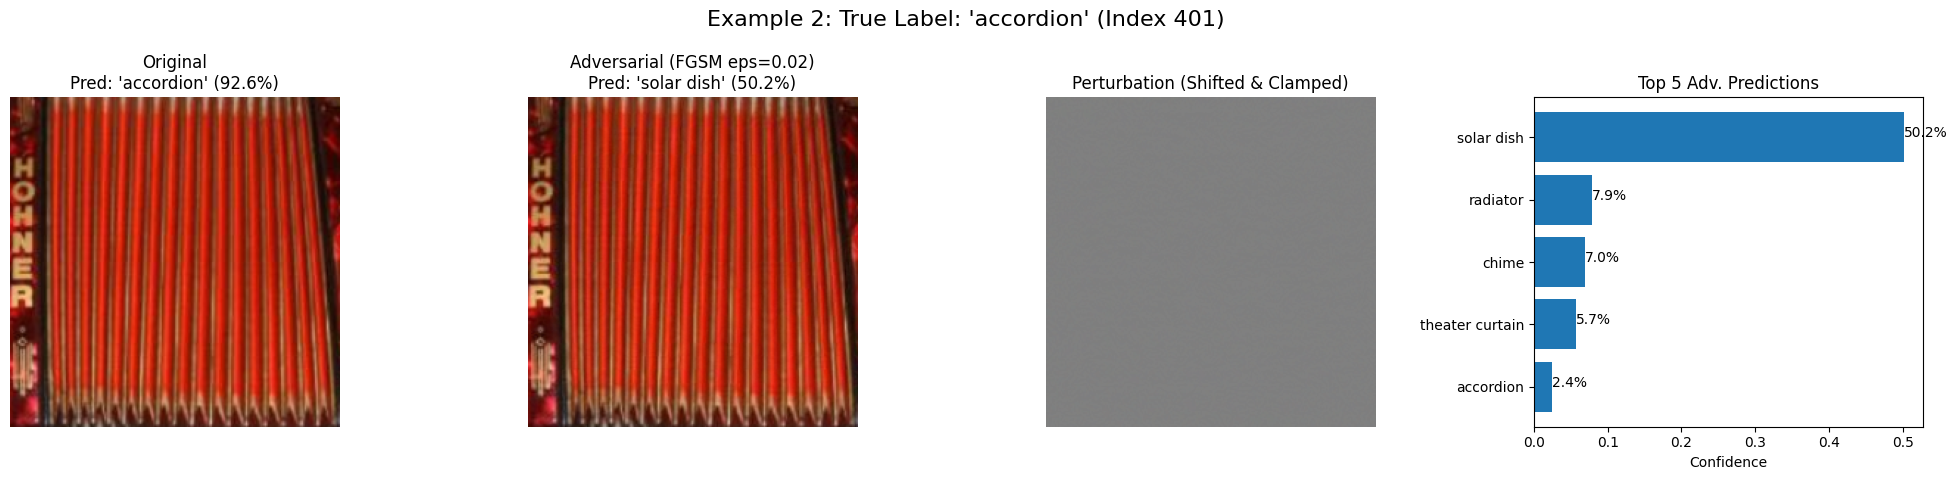

  Attack SUCCESSFUL for Example 2: Original was correct, adversarial is incorrect.


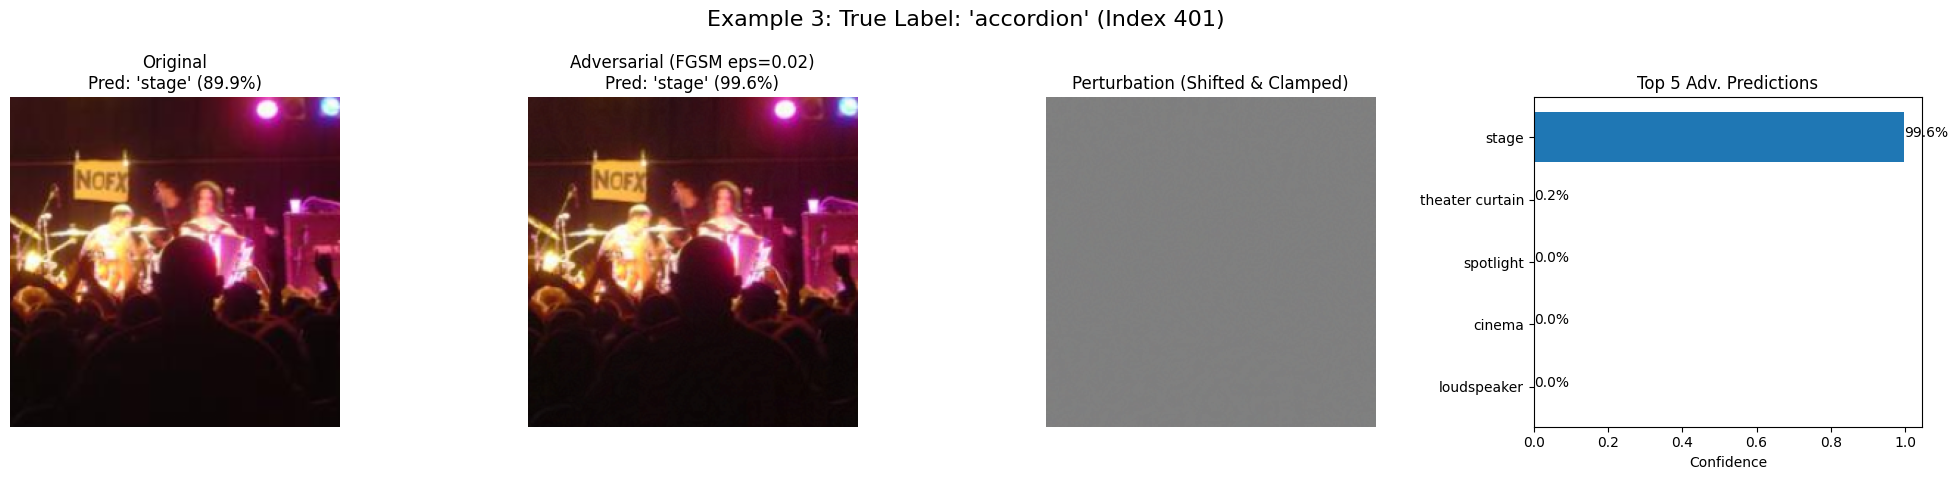

  Note for Example 3: Original model was ALREADY INCORRECT for this image.


In [16]:
# Cell 12: Visualize Adversarial Examples
# This cell will display a few original images, their adversarial counterparts,
# the perturbation, and the model's predictions for both.




# print("--- Debugging Cell 12 Variable Availability ---")
# variables_to_check_in_cell12 = [
#     'model', 'adv_images_full_tensor_t2', 'original_images_full_tensor', 
#     'original_labels_full_tensor_t2', 'MODEL_1000_CLASS_NAMES', 
#     'MEAN_NORMS', 'STD_NORMS', 'DEVICE', 'unnormalize_tensor'
# ]

# for var_name in variables_to_check_in_cell12:
#     is_global = var_name in globals()
#     is_local = var_name in locals()
    
#     if is_global or is_local:
#         var_value = globals().get(var_name, locals().get(var_name)) # Get the variable's value
#         type_info = type(var_value).__name__
#         shape_info = f"Shape: {var_value.shape}" if hasattr(var_value, 'shape') and isinstance(var_value, torch.Tensor) else ""
        
#         print(f"Variable '{var_name}': IS AVAILABLE. Type: {type_info}. {shape_info}")
#         if var_name == 'unnormalize_tensor' and not callable(var_value):
#              print(f"    WARNING: '{var_name}' is available but NOT CALLABLE (not a function).")
#     else:
#         print(f"Variable '{var_name}': IS MISSING or not in globals()/locals().")
# print("--- End Debugging for Cell 12 ---")



if not all(k in globals() or k in locals() for k in ['model', 'adv_images_full_tensor_t2', 'original_images_full_tensor', 
                                                    'original_labels_full_tensor_t2', 'MODEL_1000_CLASS_NAMES', 
                                                    'MEAN_NORMS', 'STD_NORMS', 'DEVICE', 'unnormalize_tensor']):
    print("Skipping visualization: Not all required variables are available. Please run previous cells.")
else:
    num_examples_to_visualize = 3 # Project asks for 3-5 [Source 26]
    
    # Ensure we don't try to visualize more examples than we have
    num_examples_to_visualize = min(num_examples_to_visualize, len(adv_images_full_tensor_t2))

    if num_examples_to_visualize == 0:
        print("No adversarial examples available to visualize.")
    else:
        print(f"Visualizing {num_examples_to_visualize} adversarial examples...")
        
        model.eval() # Ensure model is in eval mode
        
        for i in range(num_examples_to_visualize):
            original_img_norm = original_images_full_tensor[i].unsqueeze(0).to(DEVICE) # Add batch dim and move to device
            adv_img_norm = adv_images_full_tensor_t2[i].unsqueeze(0).to(DEVICE)       # Add batch dim and move to device
            true_global_label_idx = original_labels_full_tensor_t2[i].item() # This is the global ResNet index
            
            true_label_name = "Unknown (check mapping)"
            if 0 <= true_global_label_idx < len(MODEL_1000_CLASS_NAMES):
                 true_label_name = MODEL_1000_CLASS_NAMES[true_global_label_idx]
            
            # Get predictions for original image
            with torch.no_grad():
                original_logits = model(original_img_norm)
                original_probs = F.softmax(original_logits, dim=1)
                original_top_prob, original_pred_idx = torch.max(original_probs, 1)
                original_pred_name = MODEL_1000_CLASS_NAMES[original_pred_idx.item()]

            # Get predictions for adversarial image
            with torch.no_grad():
                adv_logits = model(adv_img_norm)
                adv_probs = F.softmax(adv_logits, dim=1)
                adv_top_prob, adv_pred_idx = torch.max(adv_probs, 1)
                adv_pred_name = MODEL_1000_CLASS_NAMES[adv_pred_idx.item()]
                
                # For the bar chart (top 5 for adversarial)
                adv_top5_probs, adv_top5_indices = torch.topk(adv_probs, 5, dim=1)
                adv_top5_names = [MODEL_1000_CLASS_NAMES[idx.item()] for idx in adv_top5_indices.squeeze()]
                adv_top5_probs_squeezed = adv_top5_probs.squeeze().cpu().numpy()

            # Unnormalize images for display
            original_img_display = unnormalize_tensor(original_img_norm.squeeze(0).cpu(), MEAN_NORMS, STD_NORMS)
            adv_img_display = unnormalize_tensor(adv_img_norm.squeeze(0).cpu(), MEAN_NORMS, STD_NORMS)
            perturbation_display = adv_img_display - original_img_display 
            # It's common to amplify the perturbation for visualization, or show its absolute values
            # For simplicity, we show raw perturbation here. It might be very subtle.
            # To make it more visible: perturbation_display_amplified = torch.clamp((perturbation_display * 10) + 0.5, 0, 1)
            
            # Plotting
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))
            fig.suptitle(f"Example {i+1}: True Label: '{true_label_name}' (Index {true_global_label_idx})", fontsize=16)

            # Original Image
            axs[0].imshow(original_img_display.permute(1, 2, 0)) # CHW to HWC for imshow
            axs[0].set_title(f"Original\nPred: '{original_pred_name}' ({original_top_prob.item()*100:.1f}%)")
            axs[0].axis('off')

            # Adversarial Image
            axs[1].imshow(adv_img_display.permute(1, 2, 0))
            axs[1].set_title(f"Adversarial (FGSM eps={EPSILON_TASK2})\nPred: '{adv_pred_name}' ({adv_top_prob.item()*100:.1f}%)")
            axs[1].axis('off')

            # Perturbation (Noise)
            # To make noise visible, often we show (perturbation - min_val) / (max_val - min_val) or add 0.5
            perturbation_vis = torch.clamp(perturbation_display + 0.5, 0, 1) # Shift by 0.5 and clamp to make negative values visible
            axs[2].imshow(perturbation_vis.permute(1, 2, 0))
            axs[2].set_title("Perturbation (Shifted & Clamped)")
            axs[2].axis('off')
            
            # Predictions Bar Chart (for adversarial image)
            bar_positions = np.arange(len(adv_top5_names))
            axs[3].barh(bar_positions, adv_top5_probs_squeezed, align='center')
            axs[3].set_yticks(bar_positions)
            axs[3].set_yticklabels(adv_top5_names)
            axs[3].invert_yaxis() # Highest probability at the top
            axs[3].set_xlabel("Confidence")
            axs[3].set_title("Top 5 Adv. Predictions")
            for index, value in enumerate(adv_top5_probs_squeezed):
                 axs[3].text(value, index, f"{value*100:.1f}%")


            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
            plt.show()
            
            # Verify if the attack was successful (original correct, adversarial incorrect)
            if original_pred_idx.item() == true_global_label_idx and adv_pred_idx.item() != true_global_label_idx:
                print(f"  Attack SUCCESSFUL for Example {i+1}: Original was correct, adversarial is incorrect.")
            elif original_pred_idx.item() != true_global_label_idx:
                 print(f"  Note for Example {i+1}: Original model was ALREADY INCORRECT for this image.")
            else: # original correct, adversarial also correct
                 print(f"  Attack FAILED for Example {i+1}: Adversarial prediction is still correct.")

In [17]:
# Cell 13: Evaluate ResNet-34 on "Adversarial Test Set 1"

if 'adv_dataloader_t2' in locals() and 'model' in locals():
    print("\n--- Evaluating ResNet-34 on 'Adversarial Test Set 1' (FGSM attacked data) ---")
    
    # Option 1: Use the generic evaluate_model_on_dataset function defined earlier
    # This function expects the dataloader to yield (images, TRUE_GLOBAL_RESNET_INDICES)
    # Our adv_dataloader_t2 (from TensorDataset) was created this way.
    
    # If you defined evaluate_model_on_dataset as suggested previously:
    if 'evaluate_model_on_dataset' in locals():
         fgsm_top1_acc, fgsm_top5_acc = evaluate_model_on_dataset(model, adv_dataloader_t2, DEVICE)
    else:
        # Fallback: Manually adapt the evaluation loop from Cell 7 if the function wasn't defined
        # or if you prefer to re-paste and ensure labels are handled correctly for this specific dataloader
        print("Helper function 'evaluate_model_on_dataset' not found. Adapting evaluation loop manually (ensure labels are global):")
        model.eval() 
        top1_correct_adv = 0
        top5_correct_adv = 0
        total_samples_adv = 0

        with torch.no_grad():
            for images_adv_batch, true_global_labels_adv_batch in adv_dataloader_t2:
                images_adv_batch = images_adv_batch.to(DEVICE)
                true_global_labels_adv_batch = true_global_labels_adv_batch.to(DEVICE) # These are already global indices
                
                outputs_adv_batch = model(images_adv_batch)
                _, top5_predicted_global_indices_adv_batch = torch.topk(outputs_adv_batch, k=5, dim=1)
                
                for i in range(images_adv_batch.size(0)):
                    true_global_idx_sample_adv = true_global_labels_adv_batch[i].item()
                    total_samples_adv += 1
                    
                    if top5_predicted_global_indices_adv_batch[i, 0].item() == true_global_idx_sample_adv:
                        top1_correct_adv += 1
                    
                    if true_global_idx_sample_adv in top5_predicted_global_indices_adv_batch[i, :].tolist():
                        top5_correct_adv += 1
        
        if total_samples_adv > 0:
            fgsm_top1_acc = (top1_correct_adv / total_samples_adv) * 100
            fgsm_top5_acc = (top5_correct_adv / total_samples_adv) * 100
            print(f"Evaluation on {total_samples_adv} adversarial samples:")
            print(f"  Top-1 Accuracy on Adversarial Test Set 1: {top1_correct_adv}/{total_samples_adv} = {fgsm_top1_acc:.2f}%")
            print(f"  Top-5 Accuracy on Adversarial Test Set 1: {top5_correct_adv}/{total_samples_adv} = {fgsm_top5_acc:.2f}%")
        else:
            print("No adversarial samples evaluated.")
            fgsm_top1_acc, fgsm_top5_acc = 0.0, 0.0

    # Compare with baseline from Task 1 (assuming you have these values stored or from Cell 7's output)
    # Example: task1_top1_accuracy = 70.60 # From your previous run
    #          task1_top5_accuracy = 93.20 # From your previous run
    # You should fetch these values programmatically or ensure they are correctly noted.
    # For now, let's just print the FGSM results. You'll do the comparison in your report.
    print("\nRemember to compare these accuracies with your baseline accuracies from Task 1 in your report.")
    print("Task 1 Baseline Top-1 (example): 70.60%") # Replace with your actual Task 1 Top-1
    print("Task 1 Baseline Top-5 (example): 93.20%") # Replace with your actual Task 1 Top-5
    print(f"FGSM (eps={EPSILON_TASK2}) Top-1: {fgsm_top1_acc:.2f}%")
    print(f"FGSM (eps={EPSILON_TASK2}) Top-5: {fgsm_top5_acc:.2f}%")
    
    # Check for 50% relative drop goal [Source 30]
    # Example: if baseline_top1 was 70.60, target is < 35.30
    #          if baseline_top5 was 93.20, target is < 46.60
    # Add your actual baseline values here for the check
    # baseline_t1 = ... # your task 1 top-1
    # if fgsm_top1_acc < baseline_t1 * 0.5:
    #    print("FGSM Top-1 accuracy drop goal (50% relative reduction) likely MET or EXCEEDED.")
    # else:
    #    print("FGSM Top-1 accuracy drop goal (50% relative reduction) NOT MET.")

else:
    print("Skipping evaluation of Adversarial Test Set 1 as 'adv_dataloader_t2' or 'model' is not available.")


--- Evaluating ResNet-34 on 'Adversarial Test Set 1' (FGSM attacked data) ---
Evaluation on 500 samples:
  Top-1 Accuracy: 25/500 = 5.00%
  Top-5 Accuracy: 151/500 = 30.20%

Remember to compare these accuracies with your baseline accuracies from Task 1 in your report.
Task 1 Baseline Top-1 (example): 70.60%
Task 1 Baseline Top-5 (example): 93.20%
FGSM (eps=0.02) Top-1: 5.00%
FGSM (eps=0.02) Top-5: 30.20%


In [18]:
# Cell 14: Define PGD Attack Function

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Ensure MEAN_NORMS and STD_NORMS are available from Cell 2, and DEVICE from Cell 2
# Ensure criterion (loss function) is available from Cell 9 (e.g., nn.CrossEntropyLoss())

def pgd_attack(model, loss_function, images_batch, true_global_labels_batch, epsilon, num_iterations, alpha, device, data_mean, data_std):
    """
    Generates adversarial images using the Projected Gradient Descent (PGD) attack.

    Args:
        model: The model to attack.
        loss_function: The loss function (e.g., nn.CrossEntropyLoss).
        images_batch: A batch of original input images (normalized tensors, NCHW format).
        true_global_labels_batch: True labels for the images (global ResNet indices).
        epsilon: The maximum L_infinity perturbation allowed.
        num_iterations: Number of PGD iterations.
        alpha: Step size for each iteration.
        device: The device to perform computations on (e.g., 'cuda' or 'cpu').
        data_mean: Dataset mean for each channel (used for clipping to valid image range).
        data_std: Dataset std for each channel (used for clipping to valid image range).

    Returns:
        adv_images_batch: Batch of adversarial images (normalized tensors).
    """
    # Clone the original images to ensure we don't modify them directly
    adv_images_batch = images_batch.clone().detach().to(device)
    original_images_for_projection = images_batch.clone().detach().to(device) # Keep original for projection
    true_global_labels_batch = true_global_labels_batch.to(device)

    # Reshape mean and std for broadcasting with image tensor (NCHW)
    # These are for clipping to the valid *normalized* image range later.
    if isinstance(data_mean, np.ndarray):
        data_mean_tensor = torch.tensor(data_mean, dtype=torch.float32, device=device).view(1, -1, 1, 1)
        data_std_tensor = torch.tensor(data_std, dtype=torch.float32, device=device).view(1, -1, 1, 1)
    else: # Assuming they are already tensors
        data_mean_tensor = data_mean.view(1, -1, 1, 1).to(device)
        data_std_tensor = data_std.view(1, -1, 1, 1).to(device)

    min_vals_normalized = (0.0 - data_mean_tensor) / data_std_tensor
    max_vals_normalized = (1.0 - data_mean_tensor) / data_std_tensor

    for _ in range(num_iterations):
        adv_images_batch.requires_grad_(True) # Enable gradient computation for the current adversarial images
        model.zero_grad()

        outputs = model(adv_images_batch)
        loss = loss_function(outputs, true_global_labels_batch)
        loss.backward()

        with torch.no_grad(): # We don't want to track gradients for the update step
            # Collect the gradients
            gradients = adv_images_batch.grad.data

            # FGSM-like step
            adv_images_batch = adv_images_batch + alpha * gradients.sign()

            # Projection step: Clip the perturbation to be within the L_infinity ball
            # ensures adv_images_batch stays within [original_images_for_projection - epsilon, original_images_for_projection + epsilon]
            perturbation = torch.clamp(adv_images_batch - original_images_for_projection, -epsilon, epsilon)
            adv_images_batch = original_images_for_projection + perturbation
            
            # Final clip to ensure valid normalized image range (e.g., approx [-2, 2] depending on mean/std)
            adv_images_batch = torch.max(torch.min(adv_images_batch, max_vals_normalized), min_vals_normalized)
            
            # Detach for the next iteration, unless it's the last one
            adv_images_batch = adv_images_batch.detach()

    return adv_images_batch

# --- Define PGD parameters for Task 3 ---
EPSILON_TASK3 = 0.02  # As per project spec ([Source 32, 33] implies same epsilon)
NUM_ITERATIONS_TASK3 = 10
ALPHA_TASK3 = EPSILON_TASK3 / 4 # A common choice, e.g., 0.02 / 4 = 0.005

# Ensure 'criterion' (loss function) from Cell 9 is available
if 'criterion' not in globals() and 'criterion' not in locals():
    criterion = nn.CrossEntropyLoss() # Define if not already present


print("PGD attack function defined.")
print(f"Parameters for Task 3 PGD:")
print(f"  Epsilon (L-infinity budget): {EPSILON_TASK3}")
print(f"  Number of iterations: {NUM_ITERATIONS_TASK3}")
print(f"  Step size (alpha): {ALPHA_TASK3}")
print(f"  Loss function for attack: CrossEntropyLoss (expected from Cell 9 or defined here)")

PGD attack function defined.
Parameters for Task 3 PGD:
  Epsilon (L-infinity budget): 0.02
  Number of iterations: 10
  Step size (alpha): 0.005
  Loss function for attack: CrossEntropyLoss (expected from Cell 9 or defined here)


In [19]:
# Cell 15: Generate Adversarial Test Set 2 (using PGD)


if not all(k in globals() or k in locals() for k in [
    'model', 'test_dataloader', 'test_dataset', 'folder_name_to_resnet_idx',
    'DEVICE', 'MEAN_NORMS', 'STD_NORMS', 'criterion', 'pgd_attack',
    'EPSILON_TASK3', 'NUM_ITERATIONS_TASK3', 'ALPHA_TASK3'
]):
    print("ERROR: Not all required variables from previous cells are available. Please re-run previous cells.")
else:
    print(f"Starting generation of 'Adversarial Test Set 2' using PGD...")
    print(f"  PGD Parameters: Epsilon={EPSILON_TASK3}, Iterations={NUM_ITERATIONS_TASK3}, Alpha={ALPHA_TASK3}")

    adversarial_images_list_t3 = []  # To store PGD adversarial image tensors
    original_true_labels_list_t3 = [] # To store corresponding true global labels

    model.eval() # Ensure model is in evaluation mode

    processed_batches_t3 = 0
    for original_images_batch, local_labels_idx_batch in test_dataloader:
        original_images_batch = original_images_batch.to(DEVICE)

        # Convert local ImageFolder labels to the global ResNet indices (0-999)
        batch_true_global_indices_list = []
        for local_idx in local_labels_idx_batch:
            folder_name = test_dataset.classes[local_idx.item()]
            if folder_name in folder_name_to_resnet_idx:
                batch_true_global_indices_list.append(folder_name_to_resnet_idx[folder_name])
            else:
                print(f"  Warning: Could not find global index for folder '{folder_name}' during PGD. Appending -1.")
                batch_true_global_indices_list.append(-1) # Placeholder

        true_global_labels_batch_tensor = torch.tensor(batch_true_global_indices_list, dtype=torch.long, device=DEVICE)

        # Filter out samples where label mapping failed (if any)
        # PGD attack function expects valid labels for loss calculation.
        valid_indices_for_attack = (true_global_labels_batch_tensor != -1)
        
        if not torch.all(valid_indices_for_attack):
            # If there are invalid labels, only attack the valid ones.
            # This part can be complex if batches become very small. For simplicity,
            # we'll assume most are valid or the loss function handles negative labels gracefully (CrossEntropy usually doesn't).
            # A robust way is to filter original_images_batch and true_global_labels_batch_tensor.
            # For now, we proceed, but be mindful if errors occur in pgd_attack due to label -1.
            # If CrossEntropyLoss fails with -1, then images_batch and labels_batch must be filtered.
            # Let's assume pgd_attack will be called on the full batch for simplicity,
            # but if specific indices are problematic, this needs refinement.
            # A simple filter:
            # current_original_images = original_images_batch[valid_indices_for_attack]
            # current_true_labels = true_global_labels_batch_tensor[valid_indices_for_attack]
            # if current_original_images.size(0) == 0: continue # Skip if no valid samples
            # else: use current_original_images, current_true_labels for attack
            pass # Assuming for now the function or subsequent logic handles it or most labels are valid.


        # Generate PGD adversarial images for the current batch
        adv_batch_t3 = pgd_attack(
            model,
            criterion,
            original_images_batch, # Pass the full batch
            true_global_labels_batch_tensor, # Pass the full labels tensor
            EPSILON_TASK3,
            NUM_ITERATIONS_TASK3,
            ALPHA_TASK3,
            DEVICE,
            MEAN_NORMS, # Pass numpy array or tensor
            STD_NORMS   # Pass numpy array or tensor
        )

        # Store the generated adversarial images (on CPU) and their original true labels
        adversarial_images_list_t3.append(adv_batch_t3.cpu())
        original_true_labels_list_t3.append(true_global_labels_batch_tensor.cpu()) # Store the global labels

        processed_batches_t3 += 1
        if processed_batches_t3 % 5 == 0 or processed_batches_t3 == len(test_dataloader):
            print(f"  PGD: Processed batch {processed_batches_t3}/{len(test_dataloader)}...")

    # Concatenate all batches to form the full adversarial dataset tensors for Task 3
    if adversarial_images_list_t3:
        adv_images_full_tensor_t3 = torch.cat(adversarial_images_list_t3, dim=0)
        original_labels_full_tensor_t3 = torch.cat(original_true_labels_list_t3, dim=0)

        # Create a TensorDataset for "Adversarial Test Set 2"
        adv_dataset_t3 = torch.utils.data.TensorDataset(adv_images_full_tensor_t3, original_labels_full_tensor_t3)

        # Create a DataLoader for this adversarial dataset
        adv_dataloader_t3 = DataLoader(adv_dataset_t3, batch_size=BATCH_SIZE, shuffle=False) # BATCH_SIZE from Cell 2

        print(f"\n'Adversarial Test Set 2' (PGD) created with {len(adv_dataset_t3)} samples.")
        print("It is now available as 'adv_dataloader_t3'.")
        print(f"  Shape of PGD adversarial images tensor: {adv_images_full_tensor_t3.shape}")
        print(f"  Shape of PGD original labels tensor: {original_labels_full_tensor_t3.shape}")
    else:
        print("ERROR: No PGD adversarial examples were generated. Check for errors in the loop.")

Starting generation of 'Adversarial Test Set 2' using PGD...
  PGD Parameters: Epsilon=0.02, Iterations=10, Alpha=0.005
  PGD: Processed batch 5/16...
  PGD: Processed batch 10/16...
  PGD: Processed batch 15/16...
  PGD: Processed batch 16/16...

'Adversarial Test Set 2' (PGD) created with 500 samples.
It is now available as 'adv_dataloader_t3'.
  Shape of PGD adversarial images tensor: torch.Size([500, 3, 224, 224])
  Shape of PGD original labels tensor: torch.Size([500])


In [20]:
torch.save(adv_images_full_tensor_t3, 'adversarial_test_set_2_images.pt')
torch.save(original_labels_full_tensor_t3, 'adversarial_test_set_2_labels.pt')
print("Adversarial Test Set 2 (PGD Full) images and labels saved.")

Adversarial Test Set 2 (PGD Full) images and labels saved.


In [21]:
# Cell 16: Verify L-infinity Distance for Adversarial Test Set 2 (PGD)

# Ensure necessary variables are available:
# adv_images_full_tensor_t3 (from Cell 15)
# original_images_full_tensor (SHOULD BE from Cell 11 - contains original normalized images)
# EPSILON_TASK3 (from Cell 14)
# unnormalize_tensor (function defined in Cell 11)
# MEAN_NORMS, STD_NORMS (from Cell 2 for unnormalize_tensor)

# First, let's ensure 'original_images_full_tensor' is available.
# If Cell 11 was run, it should exist. If not, we might need to quickly recreate it.
if 'original_images_full_tensor' not in globals() or original_images_full_tensor is None:
    print("Warning: 'original_images_full_tensor' not found or is None. Attempting to recollect from 'test_dataloader'.")
    original_images_for_comparison_list = []
    if 'test_dataloader' in locals() and test_dataloader:
        for orig_imgs_batch, _ in test_dataloader: # Iterate through original dataloader again
            original_images_for_comparison_list.append(orig_imgs_batch) # These are normalized
        
        if original_images_for_comparison_list:
            try:
                original_images_full_tensor = torch.cat(original_images_for_comparison_list, dim=0)
                print(f"Successfully re-collected 'original_images_full_tensor' with shape: {original_images_full_tensor.shape}")
            except Exception as e:
                print(f"Error concatenating original images: {e}")
                original_images_full_tensor = None # Ensure it's None on error
        else:
            print("Error: 'original_images_for_comparison_list' was empty. 'original_images_full_tensor' not created.")
    else:
        print("Error: 'test_dataloader' is not available. Cannot recollect original images for L-inf check.")

# Ensure 'unnormalize_tensor' function is available (expected from Cell 11)
if 'unnormalize_tensor' not in globals() or not callable(unnormalize_tensor):
    print("ERROR: 'unnormalize_tensor' function is not defined or not callable. Please ensure Cell 11 was run correctly.")
    # You might need to re-define it here if Cell 11 has issues or was skipped.
    # For brevity, we assume it's defined.
else:
    print("Helper function 'unnormalize_tensor' is available.")


# Proceed with L-infinity check only if all necessary tensors are available
if ('adv_images_full_tensor_t3' in locals() and adv_images_full_tensor_t3 is not None and
    'original_images_full_tensor' in locals() and original_images_full_tensor is not None and
    'EPSILON_TASK3' in globals()):

    print(f"\nVerifying L-infinity distance for 'Adversarial Test Set 2' (PGD, epsilon={EPSILON_TASK3})...")
    num_examples_to_check = 5 # Check a few examples

    if len(original_images_full_tensor) == len(adv_images_full_tensor_t3):
        max_linf_dist_found = 0.0
        all_within_epsilon = True
        for i in range(min(num_examples_to_check, len(adv_images_full_tensor_t3))):
            # Images are already normalized as they come from dataloader / attack functions
            original_img_norm = original_images_full_tensor[i]
            adversarial_img_norm = adv_images_full_tensor_t3[i]

            # Calculate perturbation in the normalized space
            perturbation_norm = adversarial_img_norm - original_img_norm
            l_infinity_dist_norm = torch.max(torch.abs(perturbation_norm)).item()
            max_linf_dist_found = max(max_linf_dist_found, l_infinity_dist_norm)

            print(f"  Example {i+1}:")
            print(f"    L-infinity distance (normalized space): {l_infinity_dist_norm:.6f}")
            
            # Check if this specific example exceeds epsilon with a small tolerance
            if l_infinity_dist_norm - EPSILON_TASK3 > 1e-5: # 1e-5 is a small tolerance for floating point
                print(f"    WARNING: L_infinity distance {l_infinity_dist_norm:.6f} is greater than epsilon {EPSILON_TASK3:.6f}!")
                all_within_epsilon = False
        
        print(f"\n  Maximum L-infinity distance found in the first {num_examples_to_check} checked samples: {max_linf_dist_found:.6f}")
        if all_within_epsilon and max_linf_dist_found <= EPSILON_TASK3 + 1e-5:
            print(f"  All checked samples are within the L-infinity budget of {EPSILON_TASK3}.")
        else:
            print(f"  WARNING: Some checked samples might have exceeded the L-infinity budget of {EPSILON_TASK3}.")

    else:
        print(f"Warning: Number of original images ({len(original_images_full_tensor) if original_images_full_tensor is not None else 'None'}) "
              f"does not match number of PGD adversarial images ({len(adv_images_full_tensor_t3) if adv_images_full_tensor_t3 is not None else 'None'}). "
              "Cannot perform L-infinity verification accurately.")
else:
    print("\nSkipping L-infinity check for PGD set due to missing prerequisite variables "
          "('adv_images_full_tensor_t3', 'original_images_full_tensor', or 'EPSILON_TASK3').")

Helper function 'unnormalize_tensor' is available.

Verifying L-infinity distance for 'Adversarial Test Set 2' (PGD, epsilon=0.02)...
  Example 1:
    L-infinity distance (normalized space): 0.020000
  Example 2:
    L-infinity distance (normalized space): 0.020000
  Example 3:
    L-infinity distance (normalized space): 0.020000
  Example 4:
    L-infinity distance (normalized space): 0.020000
  Example 5:
    L-infinity distance (normalized space): 0.020000

  Maximum L-infinity distance found in the first 5 checked samples: 0.020000
  All checked samples are within the L-infinity budget of 0.02.


Visualizing 3 PGD adversarial examples (Adversarial Test Set 2)...


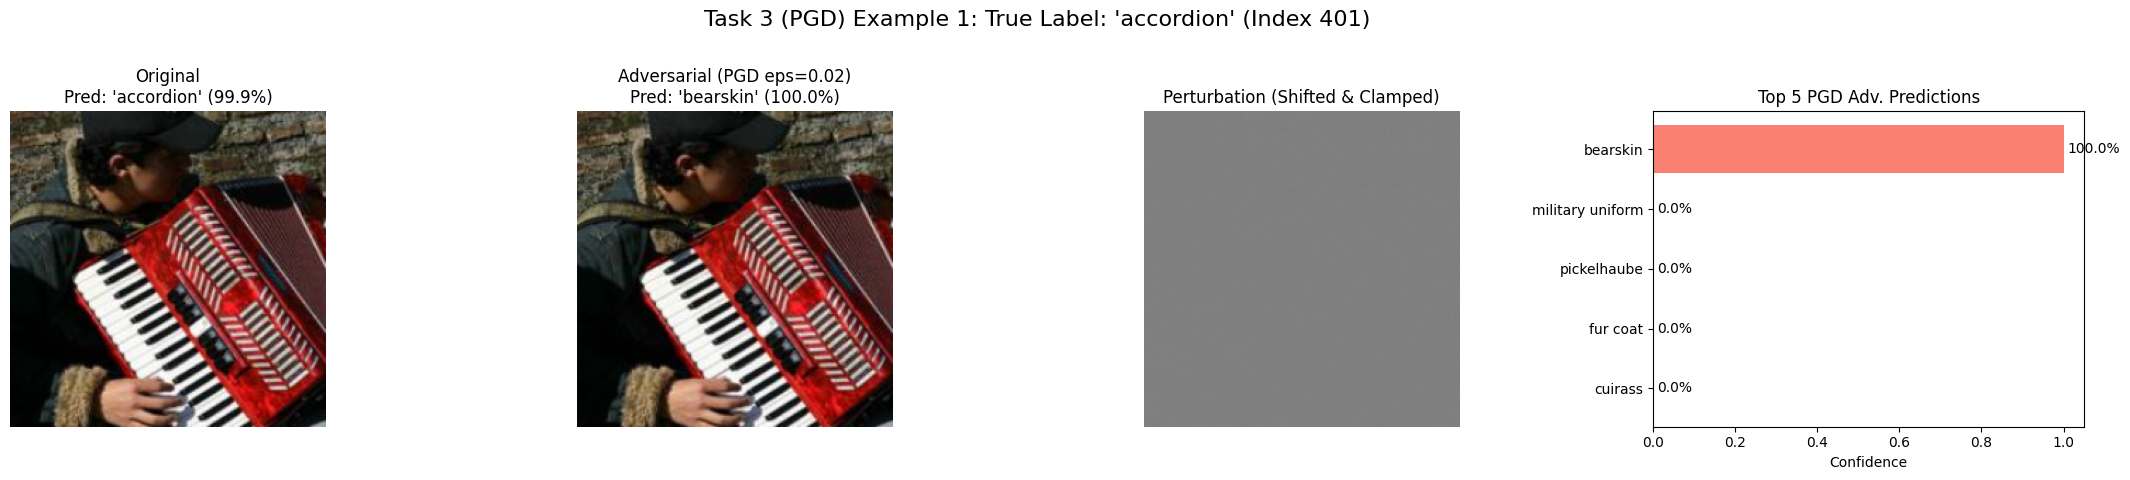

  PGD Attack SUCCESSFUL for Example 1: Original was correct, PGD adversarial is incorrect.


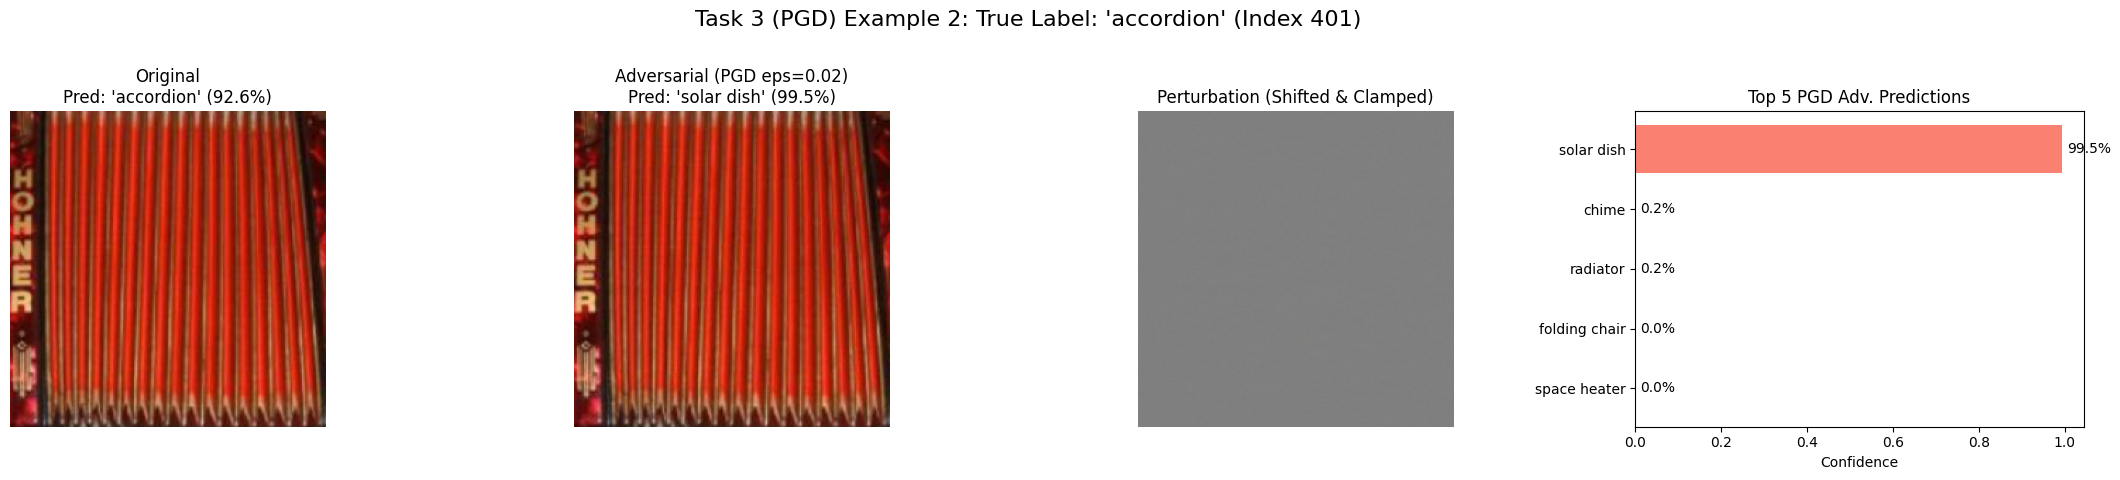

  PGD Attack SUCCESSFUL for Example 2: Original was correct, PGD adversarial is incorrect.


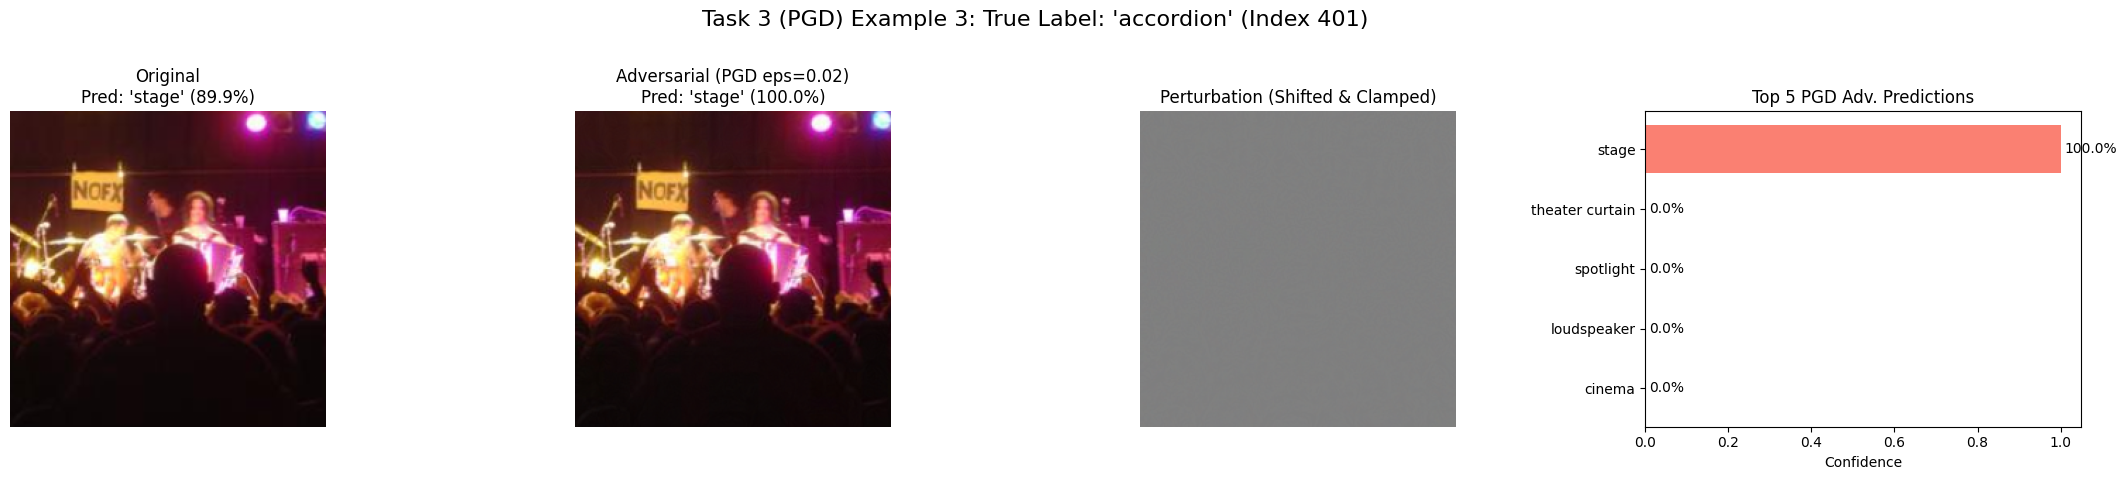

  Note for PGD Example 3: Original model was ALREADY INCORRECT for this image.


In [22]:
# Cell 17: Visualize Adversarial Examples from Adversarial Test Set 2 (PGD)

# Ensure all necessary variables are available:
# model (Cell 6),
# adv_images_full_tensor_t3 (Cell 15),
# original_images_full_tensor (Cell 11 or 16),
# original_labels_full_tensor_t3 (Cell 15 - these are global ResNet indices),
# MODEL_1000_CLASS_NAMES (Cell 5),
# MEAN_NORMS (Cell 2), STD_NORMS (Cell 2), DEVICE (Cell 2),
# unnormalize_tensor (function from Cell 11),
# EPSILON_TASK3 (Cell 14) - for titling if needed
# F (torch.nn.functional for softmax, imported in Cell 9 or globally)

if 'F' not in globals() and 'F' not in locals():
    import torch.nn.functional as F # Make sure F is imported

if not all(k in globals() or k in locals() for k in [
    'model', 'adv_images_full_tensor_t3', 'original_images_full_tensor',
    'original_labels_full_tensor_t3', 'MODEL_1000_CLASS_NAMES',
    'MEAN_NORMS', 'STD_NORMS', 'DEVICE', 'unnormalize_tensor', 'EPSILON_TASK3'
]):
    print("Skipping visualization for PGD set: Not all required variables are available. Please run previous cells.")
else:
    num_examples_to_visualize_t3 = 3 # Project asks for 3-5
    
    # Ensure we don't try to visualize more examples than we have
    num_examples_to_visualize_t3 = min(num_examples_to_visualize_t3, len(adv_images_full_tensor_t3))

    if num_examples_to_visualize_t3 == 0:
        print("No PGD adversarial examples available to visualize.")
    else:
        print(f"Visualizing {num_examples_to_visualize_t3} PGD adversarial examples (Adversarial Test Set 2)...")
        
        model.eval() # Ensure model is in eval mode
        
        for i in range(num_examples_to_visualize_t3):
            # Get original image (normalized) and its true label
            original_img_norm_t3 = original_images_full_tensor[i].unsqueeze(0).to(DEVICE) # Add batch dim
            true_global_label_idx_t3 = original_labels_full_tensor_t3[i].item() # Global ResNet index

            # Get PGD adversarial image (normalized)
            adv_img_norm_t3 = adv_images_full_tensor_t3[i].unsqueeze(0).to(DEVICE) # Add batch dim
            
            true_label_name_t3 = "Unknown (check mapping)"
            if 0 <= true_global_label_idx_t3 < len(MODEL_1000_CLASS_NAMES):
                 true_label_name_t3 = MODEL_1000_CLASS_NAMES[true_global_label_idx_t3]
            
            # Get predictions for original image
            with torch.no_grad():
                original_logits_t3 = model(original_img_norm_t3)
                original_probs_t3 = F.softmax(original_logits_t3, dim=1)
                original_top_prob_t3, original_pred_idx_t3 = torch.max(original_probs_t3, 1)
                original_pred_name_t3 = MODEL_1000_CLASS_NAMES[original_pred_idx_t3.item()]

            # Get predictions for PGD adversarial image
            with torch.no_grad():
                adv_logits_t3 = model(adv_img_norm_t3)
                adv_probs_t3 = F.softmax(adv_logits_t3, dim=1)
                adv_top_prob_t3, adv_pred_idx_t3 = torch.max(adv_probs_t3, 1)
                adv_pred_name_t3 = MODEL_1000_CLASS_NAMES[adv_pred_idx_t3.item()]
                
                # For the bar chart (top 5 for PGD adversarial)
                adv_top5_probs_t3, adv_top5_indices_t3 = torch.topk(adv_probs_t3, 5, dim=1)
                adv_top5_names_t3 = [MODEL_1000_CLASS_NAMES[idx.item()] for idx in adv_top5_indices_t3.squeeze()]
                adv_top5_probs_squeezed_t3 = adv_top5_probs_t3.squeeze().cpu().numpy()

            # Unnormalize images for display using the function from Cell 11
            original_img_display_t3 = unnormalize_tensor(original_img_norm_t3.squeeze(0).cpu(), MEAN_NORMS, STD_NORMS)
            adv_img_display_t3 = unnormalize_tensor(adv_img_norm_t3.squeeze(0).cpu(), MEAN_NORMS, STD_NORMS)
            
            # Calculate perturbation for display
            perturbation_display_t3 = adv_img_display_t3 - original_img_display_t3
            # Shift and clamp perturbation for better visibility (values around 0 become gray)
            perturbation_vis_t3 = torch.clamp(perturbation_display_t3 + 0.5, 0, 1)
            
            # Plotting
            fig, axs = plt.subplots(1, 4, figsize=(22, 5)) # Increased figsize slightly
            fig.suptitle(f"Task 3 (PGD) Example {i+1}: True Label: '{true_label_name_t3}' (Index {true_global_label_idx_t3})", fontsize=16)

            # Original Image
            axs[0].imshow(original_img_display_t3.permute(1, 2, 0)) # CHW to HWC for imshow
            axs[0].set_title(f"Original\nPred: '{original_pred_name_t3}' ({original_top_prob_t3.item()*100:.1f}%)")
            axs[0].axis('off')

            # PGD Adversarial Image
            axs[1].imshow(adv_img_display_t3.permute(1, 2, 0))
            axs[1].set_title(f"Adversarial (PGD eps={EPSILON_TASK3})\nPred: '{adv_pred_name_t3}' ({adv_top_prob_t3.item()*100:.1f}%)")
            axs[1].axis('off')

            # Perturbation (Noise)
            axs[2].imshow(perturbation_vis_t3.permute(1, 2, 0))
            axs[2].set_title("Perturbation (Shifted & Clamped)")
            axs[2].axis('off')
            
            # Predictions Bar Chart (for PGD adversarial image)
            bar_positions_t3 = np.arange(len(adv_top5_names_t3))
            axs[3].barh(bar_positions_t3, adv_top5_probs_squeezed_t3, align='center', color='salmon')
            axs[3].set_yticks(bar_positions_t3)
            axs[3].set_yticklabels(adv_top5_names_t3)
            axs[3].invert_yaxis() # Highest probability at the top
            axs[3].set_xlabel("Confidence")
            axs[3].set_title("Top 5 PGD Adv. Predictions")
            for index, value in enumerate(adv_top5_probs_squeezed_t3):
                 axs[3].text(value + 0.01, index, f"{value*100:.1f}%", va='center') # Adjusted text position

            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
            plt.show()
            
            # Verify if the attack was successful
            if original_pred_idx_t3.item() == true_global_label_idx_t3 and adv_pred_idx_t3.item() != true_global_label_idx_t3:
                print(f"  PGD Attack SUCCESSFUL for Example {i+1}: Original was correct, PGD adversarial is incorrect.")
            elif original_pred_idx_t3.item() != true_global_label_idx_t3:
                 print(f"  Note for PGD Example {i+1}: Original model was ALREADY INCORRECT for this image.")
            elif original_pred_idx_t3.item() == true_global_label_idx_t3 and adv_pred_idx_t3.item() == true_global_label_idx_t3:
                 print(f"  PGD Attack FAILED for Example {i+1}: PGD Adversarial prediction is still correct.")
            else: # Should not happen if logic above is complete
                 print(f"  Unusual case for PGD Example {i+1}: Orig Pred: {original_pred_name_t3}, Adv Pred: {adv_pred_name_t3}, True: {true_label_name_t3}")

In [23]:
# Cell 18: Evaluate ResNet-34 on "Adversarial Test Set 2" (PGD) - Using Confirmed Task 1 Baseline

# Ensure necessary variables are available:
# model (Cell 6)
# adv_dataloader_t3 (Cell 15) - DataLoader for PGD adversarial images and their true global labels
# DEVICE (Cell 2)
# evaluate_model_on_dataset (function defined in Cell 9's helper code, or re-implement if needed)
# EPSILON_TASK3, NUM_ITERATIONS_TASK3 (from Cell 14)

if not all(k in globals() or k in locals() for k in [
    'model', 'adv_dataloader_t3', 'DEVICE', 'EPSILON_TASK3', 'NUM_ITERATIONS_TASK3'
]):
    print("Skipping evaluation of PGD set: Not all required variables are available.")
elif 'evaluate_model_on_dataset' not in globals() or not callable(evaluate_model_on_dataset):
    print("Helper function 'evaluate_model_on_dataset' not found. Manually implementing evaluation loop for PGD set.")
    # Fallback: Manually adapt the evaluation loop
    model.eval()
    top1_correct_adv_t3 = 0
    top5_correct_adv_t3 = 0
    total_samples_adv_t3 = 0

    with torch.no_grad():
        for images_adv_batch_t3, true_global_labels_adv_batch_t3 in adv_dataloader_t3:
            images_adv_batch_t3 = images_adv_batch_t3.to(DEVICE)
            true_global_labels_adv_batch_t3 = true_global_labels_adv_batch_t3.to(DEVICE)

            outputs_adv_batch_t3 = model(images_adv_batch_t3)
            _, top5_predicted_global_indices_adv_batch_t3 = torch.topk(outputs_adv_batch_t3, k=5, dim=1)

            for i in range(images_adv_batch_t3.size(0)):
                true_global_idx_sample_adv_t3 = true_global_labels_adv_batch_t3[i].item()
                
                if true_global_idx_sample_adv_t3 == -1: # Skip if label was marked as invalid
                    continue
                total_samples_adv_t3 += 1

                if top5_predicted_global_indices_adv_batch_t3[i, 0].item() == true_global_idx_sample_adv_t3:
                    top1_correct_adv_t3 += 1
                if true_global_idx_sample_adv_t3 in top5_predicted_global_indices_adv_batch_t3[i, :].tolist():
                    top5_correct_adv_t3 += 1
    
    if total_samples_adv_t3 > 0:
        pgd_top1_acc = (top1_correct_adv_t3 / total_samples_adv_t3) * 100
        pgd_top5_acc = (top5_correct_adv_t3 / total_samples_adv_t3) * 100
        print(f"\n--- Evaluating ResNet-34 on 'Adversarial Test Set 2' (PGD attacked data, eps={EPSILON_TASK3}) ---")
        print(f"Evaluation on {total_samples_adv_t3} PGD adversarial samples:")
        print(f"  Top-1 Accuracy: {top1_correct_adv_t3}/{total_samples_adv_t3} = {pgd_top1_acc:.2f}%")
        print(f"  Top-5 Accuracy: {top5_correct_adv_t3}/{total_samples_adv_t3} = {pgd_top5_acc:.2f}%")
    else:
        print("No PGD adversarial samples were effectively evaluated.")
        pgd_top1_acc, pgd_top5_acc = 0.0, 0.0
else:
    print(f"\n--- Evaluating ResNet-34 on 'Adversarial Test Set 2' (PGD attacked data, eps={EPSILON_TASK3}) ---")
    pgd_top1_acc, pgd_top5_acc = evaluate_model_on_dataset(model, adv_dataloader_t3, DEVICE)

# --- Task 3 Performance Summary (PGD Attack) ---
print(f"\nPGD (eps={EPSILON_TASK3}, iterations={NUM_ITERATIONS_TASK3}) Top-1 Accuracy: {pgd_top1_acc:.2f}%")
print(f"PGD (eps={EPSILON_TASK3}, iterations={NUM_ITERATIONS_TASK3}) Top-5 Accuracy: {pgd_top5_acc:.2f}%")

# Using confirmed actual Task 1 baseline accuracies
task1_top1_actual_baseline = 70.60 # Confirmed actual baseline from Task 1 (Cell 7)
task1_top5_actual_baseline = 93.20 # Confirmed actual baseline from Task 1 (Cell 7)

print("\nComparison with Task 1 Baseline (Confirmed Actual Values):")
print(f"  Task 1 Baseline Top-1 Accuracy: {task1_top1_actual_baseline:.2f}%")
print(f"  Task 1 Baseline Top-5 Accuracy: {task1_top5_actual_baseline:.2f}%")

# Calculate target accuracies for 70% relative drop
target_top1_for_70_drop = task1_top1_actual_baseline * (1 - 0.70)
target_top5_for_70_drop = task1_top5_actual_baseline * (1 - 0.70)

print(f"\nTask 3 Goal: Achieve at least 70% relative accuracy drop from Task 1 baseline.")
print(f"  Target Top-1 Accuracy (for 70% drop from actual baseline): < {target_top1_for_70_drop:.2f}%")
print(f"  Target Top-5 Accuracy (for 70% drop from actual baseline): < {target_top5_for_70_drop:.2f}%")

if pgd_top1_acc < target_top1_for_70_drop:
    print("  PGD Top-1 accuracy MET the 70% relative drop target.")
else:
    print("  PGD Top-1 accuracy DID NOT MEET the 70% relative drop target.")

if pgd_top5_acc < target_top5_for_70_drop:
    print("  PGD Top-5 accuracy MET the 70% relative drop target.")
else:
    print("  PGD Top-5 accuracy DID NOT MEET the 70% relative drop target.")


--- Evaluating ResNet-34 on 'Adversarial Test Set 2' (PGD attacked data, eps=0.02) ---
Evaluation on 500 samples:
  Top-1 Accuracy: 0/500 = 0.00%
  Top-5 Accuracy: 36/500 = 7.20%

PGD (eps=0.02, iterations=10) Top-1 Accuracy: 0.00%
PGD (eps=0.02, iterations=10) Top-5 Accuracy: 7.20%

Comparison with Task 1 Baseline (Confirmed Actual Values):
  Task 1 Baseline Top-1 Accuracy: 70.60%
  Task 1 Baseline Top-5 Accuracy: 93.20%

Task 3 Goal: Achieve at least 70% relative accuracy drop from Task 1 baseline.
  Target Top-1 Accuracy (for 70% drop from actual baseline): < 21.18%
  Target Top-5 Accuracy (for 70% drop from actual baseline): < 27.96%
  PGD Top-1 accuracy MET the 70% relative drop target.
  PGD Top-5 accuracy MET the 70% relative drop target.


In [24]:
# Cell 19: Define Patch Targeted PGD Attack Function (Corrected)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

# Ensure MEAN_NORMS and STD_NORMS are available from Cell 2, and DEVICE from Cell 2
# Ensure criterion (loss function) is available from Cell 9/14 (e.g., nn.CrossEntropyLoss())

def patch_targeted_pgd_attack(model, loss_function, images_batch, target_labels_batch,
                              epsilon_patch, num_iterations, alpha_patch, device,
                              data_mean, data_std, patch_size=32):
    """
    Generates adversarial images using Targeted PGD attack on a random patch.
    (Corrected version for clipping)
    """
    adv_images_batch = images_batch.clone().detach().to(device)
    original_images_for_projection = images_batch.clone().detach().to(device)
    target_labels_batch = target_labels_batch.to(device)

    if isinstance(data_mean, np.ndarray):
        data_mean_tensor = torch.tensor(data_mean, dtype=torch.float32, device=device).view(1, -1, 1, 1)
        data_std_tensor = torch.tensor(data_std, dtype=torch.float32, device=device).view(1, -1, 1, 1)
    else:
        data_mean_tensor = data_mean.view(1, -1, 1, 1).to(device)
        data_std_tensor = data_std.view(1, -1, 1, 1).to(device)
    
    # These are [1, C, 1, 1]
    min_vals_normalized_full = (0.0 - data_mean_tensor) / data_std_tensor
    max_vals_normalized_full = (1.0 - data_mean_tensor) / data_std_tensor

    # For broadcasting with patch [C, H_patch, W_patch], we need [C, 1, 1]
    min_clip_bounds = min_vals_normalized_full.squeeze(0) # Shape [C, 1, 1]
    max_clip_bounds = max_vals_normalized_full.squeeze(0) # Shape [C, 1, 1]

    N, C, H, W = images_batch.shape
    original_patches_list = []
    patch_coords_list = []

    for i in range(N):
        r = random.randint(0, H - patch_size)
        c = random.randint(0, W - patch_size)
        patch_coords_list.append((r, c))
        original_patch = original_images_for_projection[i, :, r:r+patch_size, c:c+patch_size].clone().detach()
        original_patches_list.append(original_patch)

    for iteration in range(num_iterations):
        adv_images_batch.requires_grad_(True)
        model.zero_grad()
        outputs = model(adv_images_batch)
        loss = loss_function(outputs, target_labels_batch)
        loss.backward()

        with torch.no_grad():
            gradients_full = adv_images_batch.grad.data
            for i in range(N):
                r, c = patch_coords_list[i]
                original_patch = original_patches_list[i] # Shape [C, patch_size, patch_size]

                current_adv_patch = adv_images_batch[i, :, r:r+patch_size, c:c+patch_size]
                grad_patch = gradients_full[i, :, r:r+patch_size, c:c+patch_size]

                perturbed_patch = current_adv_patch - alpha_patch * grad_patch.sign()
                
                perturbation = torch.clamp(perturbed_patch - original_patch, -epsilon_patch, epsilon_patch)
                projected_patch = original_patch + perturbation
                
                # Corrected Clipping:
                # projected_patch is [C, patch_size, patch_size]
                # min_clip_bounds and max_clip_bounds are [C, 1, 1] and will broadcast correctly.
                clipped_patch = torch.max(torch.min(projected_patch, max_clip_bounds), min_clip_bounds)
                
                adv_images_batch[i, :, r:r+patch_size, c:c+patch_size] = clipped_patch
            
            adv_images_batch = adv_images_batch.detach()
    return adv_images_batch

# --- Define Patch PGD parameters for Task 4 --- (These remain the same)
PATCH_SIZE_TASK4 = 32
EPSILON_PATCH_TASK4 = 0.3
NUM_ITERATIONS_TASK4 = 20
ALPHA_PATCH_TASK4 = EPSILON_PATCH_TASK4 / 5

if 'criterion' not in globals() and 'criterion' not in locals():
    criterion = nn.CrossEntropyLoss()


print("Patch Targeted PGD attack function defined (Corrected).")
print(f"Parameters for Task 4 Patch PGD:")
print(f"  Patch Size: {PATCH_SIZE_TASK4}x{PATCH_SIZE_TASK4}")
print(f"  Epsilon for Patch (L-infinity budget on patch): {EPSILON_PATCH_TASK4}")
print(f"  Number of iterations: {NUM_ITERATIONS_TASK4}")
print(f"  Step size (alpha) for patch: {ALPHA_PATCH_TASK4}")
print(f"  Loss function for attack: CrossEntropyLoss (used with target labels)")

Patch Targeted PGD attack function defined (Corrected).
Parameters for Task 4 Patch PGD:
  Patch Size: 32x32
  Epsilon for Patch (L-infinity budget on patch): 0.3
  Number of iterations: 20
  Step size (alpha) for patch: 0.06
  Loss function for attack: CrossEntropyLoss (used with target labels)


In [25]:
# Cell 20: Generate Adversarial Test Set 3 (using Patch Targeted PGD)

# Ensure all necessary variables from previous cells are available:
# model (Cell 6), test_dataloader (Cell 4), test_dataset.classes (Cell 4),
# folder_name_to_resnet_idx (Cell 5), DEVICE (Cell 2),
# MEAN_NORMS (Cell 2), STD_NORMS (Cell 2), criterion (Cell 9, 14 or 19),
# patch_targeted_pgd_attack (Cell 19),
# EPSILON_PATCH_TASK4, NUM_ITERATIONS_TASK4, ALPHA_PATCH_TASK4, PATCH_SIZE_TASK4 (Cell 19),
# MODEL_1000_CLASS_NAMES (Cell 5, for selecting random target labels)

if not all(k in globals() or k in locals() for k in [
    'model', 'test_dataloader', 'test_dataset', 'folder_name_to_resnet_idx',
    'DEVICE', 'MEAN_NORMS', 'STD_NORMS', 'criterion', 'patch_targeted_pgd_attack',
    'EPSILON_PATCH_TASK4', 'NUM_ITERATIONS_TASK4', 'ALPHA_PATCH_TASK4', 'PATCH_SIZE_TASK4',
    'MODEL_1000_CLASS_NAMES'
]):
    print("ERROR: Not all required variables from previous cells are available for Task 4. Please re-run previous cells.")
else:
    print(f"Starting generation of 'Adversarial Test Set 3' using Patch Targeted PGD...")
    print(f"  Patch PGD Parameters: Patch Size={PATCH_SIZE_TASK4}, Epsilon={EPSILON_PATCH_TASK4}, Iterations={NUM_ITERATIONS_TASK4}, Alpha={ALPHA_PATCH_TASK4}")

    adversarial_images_list_t4 = []  # To store patch PGD adversarial image tensors
    original_true_labels_list_t4 = [] # To store corresponding true global labels (for evaluation)
    # We might also want to store the target labels used for verification/analysis, though not strictly needed for evaluation
    # selected_target_labels_list_t4 = []

    num_classes = len(MODEL_1000_CLASS_NAMES)
    model.eval() # Ensure model is in evaluation mode

    processed_batches_t4 = 0
    for original_images_batch, local_labels_idx_batch in test_dataloader:
        original_images_batch = original_images_batch.to(DEVICE) # Move original images to device

        # 1. Convert local ImageFolder labels to the global ResNet indices (true labels)
        batch_true_global_indices_list = []
        for local_idx in local_labels_idx_batch:
            folder_name = test_dataset.classes[local_idx.item()]
            if folder_name in folder_name_to_resnet_idx:
                batch_true_global_indices_list.append(folder_name_to_resnet_idx[folder_name])
            else:
                print(f"  Warning: Could not find global index for folder '{folder_name}'. Appending -1 for true label.")
                batch_true_global_indices_list.append(-1) # Placeholder for true label
        
        true_global_labels_batch_tensor = torch.tensor(batch_true_global_indices_list, dtype=torch.long, device=DEVICE)

        # 2. Select random target labels for each image in the batch
        batch_target_labels_list = []
        for true_label_idx in true_global_labels_batch_tensor:
            true_label_item = true_label_idx.item()
            if true_label_item == -1: # If true label is invalid, target label is also problematic
                batch_target_labels_list.append(-1) # Or some other indicator
                continue

            target_label_idx = random.randint(0, num_classes - 1)
            while target_label_idx == true_label_item: # Ensure target is different from true
                target_label_idx = random.randint(0, num_classes - 1)
            batch_target_labels_list.append(target_label_idx)
        
        target_labels_batch_tensor = torch.tensor(batch_target_labels_list, dtype=torch.long, device=DEVICE)
        
        # Filter out samples where true label or target label is invalid (-1) before attack
        # The attack function expects valid labels.
        valid_indices_for_attack = (true_global_labels_batch_tensor != -1) & (target_labels_batch_tensor != -1)
        
        if not torch.all(valid_indices_for_attack):
            print(f"  Note: Some samples in batch {processed_batches_t4+1} have invalid true/target labels and will be skipped for attack if filtered.")
            # For simplicity, if any invalid, we might skip the whole batch for attack or filter.
            # Let's filter the inputs to the attack function.
            
        current_original_images = original_images_batch[valid_indices_for_attack]
        current_target_labels = target_labels_batch_tensor[valid_indices_for_attack]
        # Also need to filter true_global_labels_batch_tensor if we want to store only attacked ones
        current_true_labels_for_storage = true_global_labels_batch_tensor[valid_indices_for_attack]

        if current_original_images.size(0) == 0: # If no valid samples in batch
            print(f"  Skipping batch {processed_batches_t4+1} as no valid samples for attack after filtering.")
            processed_batches_t4 += 1
            continue


        # 3. Generate Patch Targeted PGD adversarial images
        adv_batch_t4 = patch_targeted_pgd_attack(
            model,
            criterion, # Loss function
            current_original_images,
            current_target_labels, # Pass the chosen target labels
            EPSILON_PATCH_TASK4,
            NUM_ITERATIONS_TASK4,
            ALPHA_PATCH_TASK4,
            DEVICE,
            MEAN_NORMS,
            STD_NORMS,
            PATCH_SIZE_TASK4
        )

        # Store the generated adversarial images (on CPU) and their original true labels
        adversarial_images_list_t4.append(adv_batch_t4.cpu())
        original_true_labels_list_t4.append(current_true_labels_for_storage.cpu())
        # selected_target_labels_list_t4.append(current_target_labels.cpu()) # Optional to store targets

        processed_batches_t4 += 1
        if processed_batches_t4 % 5 == 0 or processed_batches_t4 == len(test_dataloader):
            print(f"  Patch PGD: Processed batch {processed_batches_t4}/{len(test_dataloader)}...")

    # Concatenate all batches to form the full adversarial dataset tensors for Task 4
    if adversarial_images_list_t4:
        adv_images_full_tensor_t4 = torch.cat(adversarial_images_list_t4, dim=0)
        original_labels_full_tensor_t4 = torch.cat(original_true_labels_list_t4, dim=0)
        # if selected_target_labels_list_t4:
        #     target_labels_full_tensor_t4 = torch.cat(selected_target_labels_list_t4, dim=0)


        # Create a TensorDataset for "Adversarial Test Set 3"
        # It stores (adversarial_image, original_true_GLOBAL_label)
        adv_dataset_t4 = torch.utils.data.TensorDataset(adv_images_full_tensor_t4, original_labels_full_tensor_t4)

        # Create a DataLoader for this adversarial dataset
        adv_dataloader_t4 = DataLoader(adv_dataset_t4, batch_size=BATCH_SIZE, shuffle=False) # BATCH_SIZE from Cell 2

        print(f"\n'Adversarial Test Set 3' (Patch Targeted PGD) created with {len(adv_dataset_t4)} samples.")
        print("It is now available as 'adv_dataloader_t4'.")
        print(f"  Shape of Patch PGD adversarial images tensor: {adv_images_full_tensor_t4.shape}")
        print(f"  Shape of original true labels tensor for t4: {original_labels_full_tensor_t4.shape}")
        # if 'target_labels_full_tensor_t4' in locals():
        #     print(f"  Shape of selected target labels tensor for t4: {target_labels_full_tensor_t4.shape}")

    else:
        print("ERROR: No Patch PGD adversarial examples were generated. Check for errors or if all batches were skipped.")

Starting generation of 'Adversarial Test Set 3' using Patch Targeted PGD...
  Patch PGD Parameters: Patch Size=32, Epsilon=0.3, Iterations=20, Alpha=0.06
  Patch PGD: Processed batch 5/16...
  Patch PGD: Processed batch 10/16...
  Patch PGD: Processed batch 15/16...
  Patch PGD: Processed batch 16/16...

'Adversarial Test Set 3' (Patch Targeted PGD) created with 500 samples.
It is now available as 'adv_dataloader_t4'.
  Shape of Patch PGD adversarial images tensor: torch.Size([500, 3, 224, 224])
  Shape of original true labels tensor for t4: torch.Size([500])


In [26]:
torch.save(adv_images_full_tensor_t4, 'adversarial_test_set_3_images.pt')
torch.save(original_labels_full_tensor_t4, 'adversarial_test_set_3_labels.pt')
print("Adversarial Test Set 3 (Patch PGD) images and labels saved.")

Adversarial Test Set 3 (Patch PGD) images and labels saved.


In [27]:
# Cell 21: Note on L-infinity for Patch Attacks and Visualization Preparation

# Ensure original_images_full_tensor (from Cell 11 or 16) is available
if 'original_images_full_tensor' not in globals() or original_images_full_tensor is None:
    print("Warning: 'original_images_full_tensor' not found. Attempting to recollect for Task 4 visualization.")
    # This logic was also in Cell 16, ensuring it's available
    original_images_for_comparison_list = []
    if 'test_dataloader' in locals() and test_dataloader:
        for orig_imgs_batch, _ in test_dataloader:
            original_images_for_comparison_list.append(orig_imgs_batch)
        if original_images_for_comparison_list:
            try:
                original_images_full_tensor = torch.cat(original_images_for_comparison_list, dim=0)
                print(f"Successfully re-collected 'original_images_full_tensor' with shape: {original_images_full_tensor.shape}")
            except Exception as e:
                print(f"Error concatenating original images: {e}")
                original_images_full_tensor = None
        else:
            print("Error: Could not recollect 'original_images_full_tensor'.")
    else:
        print("Error: 'test_dataloader' not available. Cannot recollect original images.")

# Ensure 'unnormalize_tensor' function is available (expected from Cell 11)
if 'unnormalize_tensor' not in globals() or not callable(unnormalize_tensor):
    print("ERROR: 'unnormalize_tensor' function is not defined. Please ensure Cell 11 was run correctly.")
else:
    print("Helper function 'unnormalize_tensor' is available.")

print("\n--- Note on L-infinity for Task 4 (Patch Attacks) ---")
print(f"The 'patch_targeted_pgd_attack' function (Cell 19) was designed to limit perturbations")
print(f"within the randomly selected {PATCH_SIZE_TASK4}x{PATCH_SIZE_TASK4} patch to an L-infinity norm of EPSILON_PATCH_TASK4={EPSILON_PATCH_TASK4}.")
print("This is enforced by the clamping mechanism within the attack's PGD loop on the patch itself.")
print("Visual inspection will help confirm that changes are localized to a small patch area.")
print("\nPreparation for Task 4 visualization complete.")

Helper function 'unnormalize_tensor' is available.

--- Note on L-infinity for Task 4 (Patch Attacks) ---
The 'patch_targeted_pgd_attack' function (Cell 19) was designed to limit perturbations
within the randomly selected 32x32 patch to an L-infinity norm of EPSILON_PATCH_TASK4=0.3.
This is enforced by the clamping mechanism within the attack's PGD loop on the patch itself.
Visual inspection will help confirm that changes are localized to a small patch area.

Preparation for Task 4 visualization complete.


Visualizing 3 Patch PGD adversarial examples (Adversarial Test Set 3)...


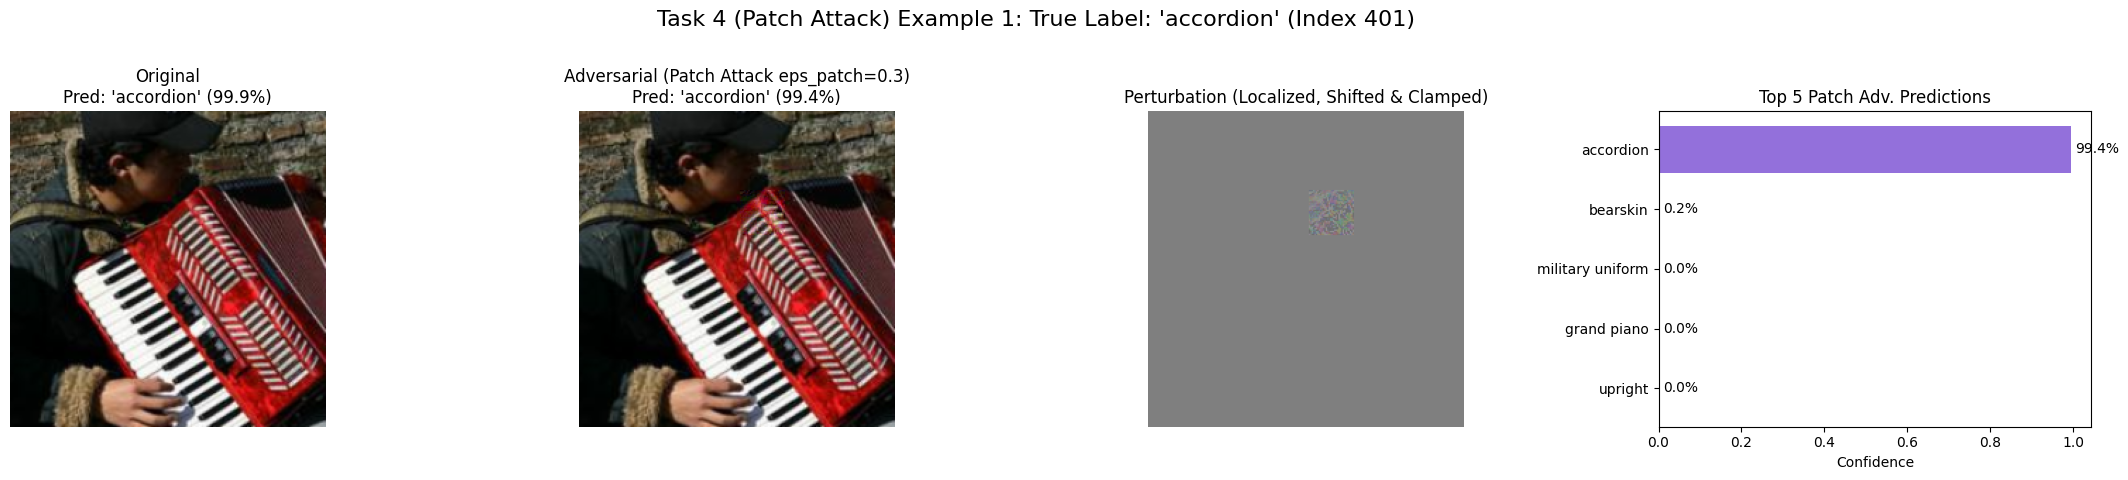

  Patch Attack FAILED to misclassify Example 1: Adversarial prediction is still correct.


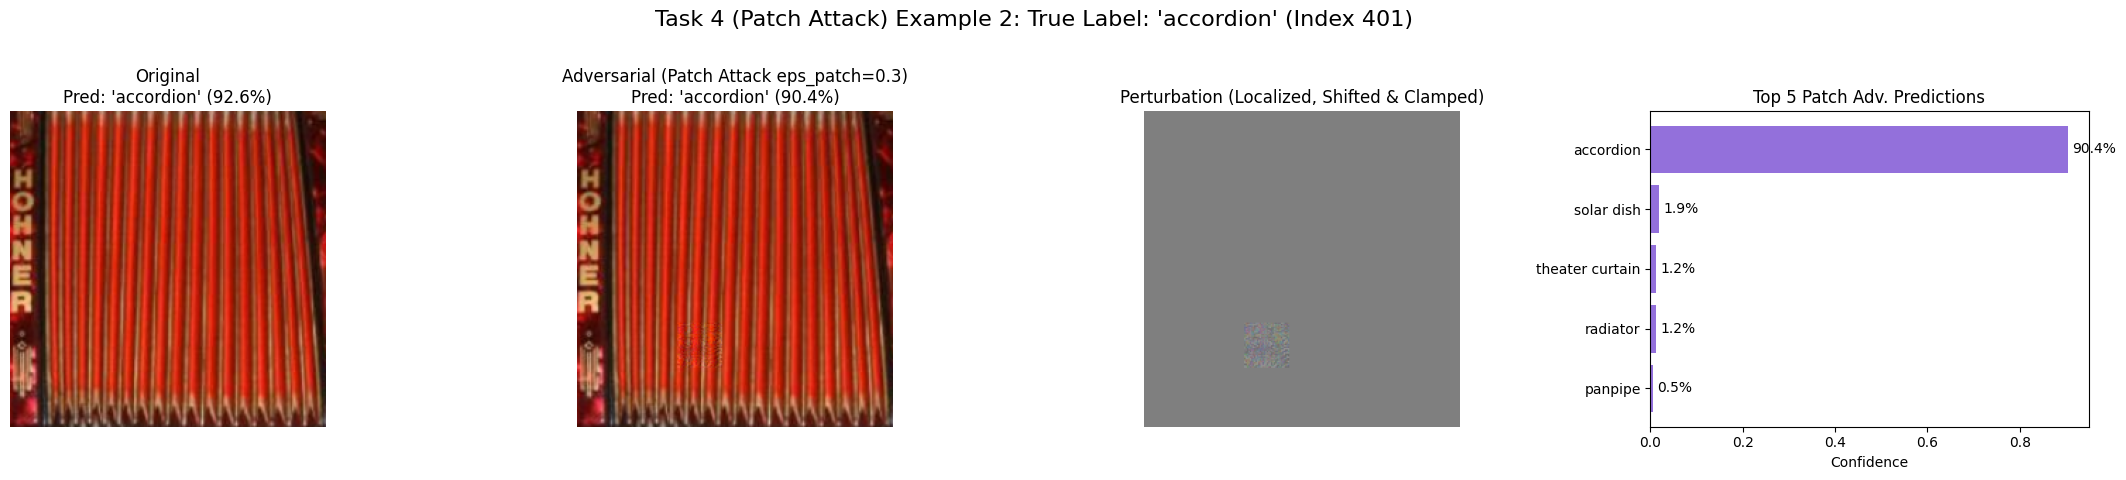

  Patch Attack FAILED to misclassify Example 2: Adversarial prediction is still correct.


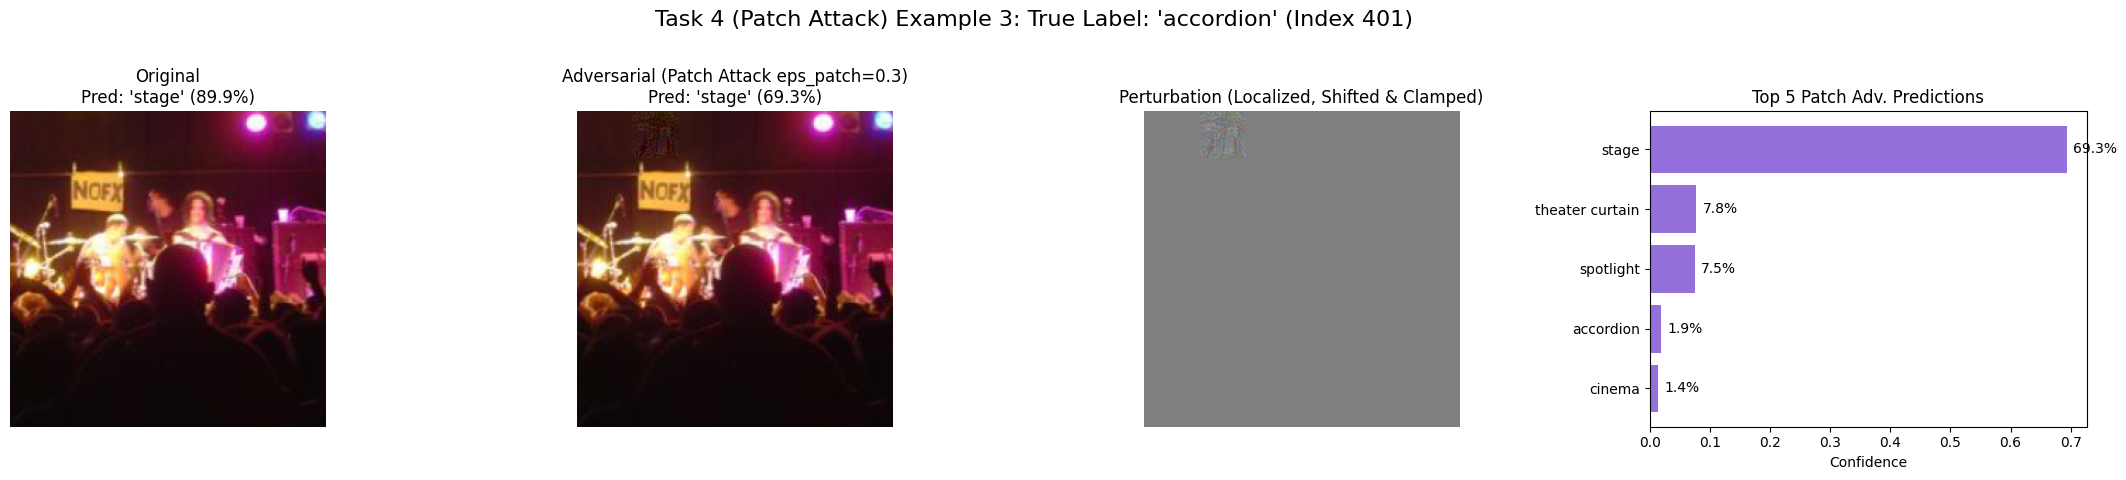

  Note for Patch Attack Example 3: Original model was ALREADY INCORRECT for this image.


In [28]:
# Cell 22: Visualize Adversarial Examples from Adversarial Test Set 3 (Patch Targeted PGD)

# Ensure all necessary variables are available from previous cells.
# model, adv_images_full_tensor_t4, original_images_full_tensor,
# original_labels_full_tensor_t4, MODEL_1000_CLASS_NAMES,
# MEAN_NORMS, STD_NORMS, DEVICE, unnormalize_tensor,
# EPSILON_PATCH_TASK4, PATCH_SIZE_TASK4
# F (torch.nn.functional for softmax)

if 'F' not in globals() and 'F' not in locals():
    import torch.nn.functional as F

if not all(k in globals() or k in locals() for k in [
    'model', 'adv_images_full_tensor_t4', 'original_images_full_tensor',
    'original_labels_full_tensor_t4', 'MODEL_1000_CLASS_NAMES',
    'MEAN_NORMS', 'STD_NORMS', 'DEVICE', 'unnormalize_tensor',
    'EPSILON_PATCH_TASK4', 'PATCH_SIZE_TASK4'
]):
    print("Skipping visualization for Patch PGD set: Not all required variables are available. Please run previous cells.")
else:
    num_examples_to_visualize_t4 = 3 # Project asks for 3-5
    num_examples_to_visualize_t4 = min(num_examples_to_visualize_t4, len(adv_images_full_tensor_t4))

    if num_examples_to_visualize_t4 == 0:
        print("No Patch PGD adversarial examples available to visualize.")
    else:
        print(f"Visualizing {num_examples_to_visualize_t4} Patch PGD adversarial examples (Adversarial Test Set 3)...")
        
        model.eval() # Ensure model is in eval mode
        
        for i in range(num_examples_to_visualize_t4):
            # Get original image (normalized) and its true label
            # Assuming original_images_full_tensor and original_labels_full_tensor_t4 are aligned by index i
            original_img_norm_t4 = original_images_full_tensor[i].unsqueeze(0).to(DEVICE)
            true_global_label_idx_t4 = original_labels_full_tensor_t4[i].item() # Global ResNet index

            # Get Patch PGD adversarial image (normalized)
            adv_img_norm_t4 = adv_images_full_tensor_t4[i].unsqueeze(0).to(DEVICE)
            
            true_label_name_t4 = "Unknown (check mapping)"
            if 0 <= true_global_label_idx_t4 < len(MODEL_1000_CLASS_NAMES):
                 true_label_name_t4 = MODEL_1000_CLASS_NAMES[true_global_label_idx_t4]
            
            # Get predictions for original image
            with torch.no_grad():
                original_logits_t4 = model(original_img_norm_t4)
                original_probs_t4 = F.softmax(original_logits_t4, dim=1)
                original_top_prob_t4, original_pred_idx_t4 = torch.max(original_probs_t4, 1)
                original_pred_name_t4 = MODEL_1000_CLASS_NAMES[original_pred_idx_t4.item()]

            # Get predictions for Patch PGD adversarial image
            with torch.no_grad():
                adv_logits_t4 = model(adv_img_norm_t4)
                adv_probs_t4 = F.softmax(adv_logits_t4, dim=1)
                adv_top_prob_t4, adv_pred_idx_t4 = torch.max(adv_probs_t4, 1)
                adv_pred_name_t4 = MODEL_1000_CLASS_NAMES[adv_pred_idx_t4.item()]
                
                adv_top5_probs_t4, adv_top5_indices_t4 = torch.topk(adv_probs_t4, 5, dim=1)
                adv_top5_names_t4 = [MODEL_1000_CLASS_NAMES[idx.item()] for idx in adv_top5_indices_t4.squeeze()]
                adv_top5_probs_squeezed_t4 = adv_top5_probs_t4.squeeze().cpu().numpy()

            # Unnormalize images for display
            original_img_display_t4 = unnormalize_tensor(original_img_norm_t4.squeeze(0).cpu(), MEAN_NORMS, STD_NORMS)
            adv_img_display_t4 = unnormalize_tensor(adv_img_norm_t4.squeeze(0).cpu(), MEAN_NORMS, STD_NORMS)
            
            # Calculate perturbation for display (difference between unnormalized display images)
            perturbation_display_t4 = adv_img_display_t4 - original_img_display_t4
            # Shift and clamp perturbation for better visibility
            perturbation_vis_t4 = torch.clamp(perturbation_display_t4 + 0.5, 0, 1) # Values around 0 become gray
            
            # Plotting
            fig, axs = plt.subplots(1, 4, figsize=(22, 5))
            fig.suptitle(f"Task 4 (Patch Attack) Example {i+1}: True Label: '{true_label_name_t4}' (Index {true_global_label_idx_t4})", fontsize=16)

            axs[0].imshow(original_img_display_t4.permute(1, 2, 0))
            axs[0].set_title(f"Original\nPred: '{original_pred_name_t4}' ({original_top_prob_t4.item()*100:.1f}%)")
            axs[0].axis('off')

            axs[1].imshow(adv_img_display_t4.permute(1, 2, 0))
            axs[1].set_title(f"Adversarial (Patch Attack eps_patch={EPSILON_PATCH_TASK4})\nPred: '{adv_pred_name_t4}' ({adv_top_prob_t4.item()*100:.1f}%)")
            axs[1].axis('off')

            axs[2].imshow(perturbation_vis_t4.permute(1, 2, 0))
            axs[2].set_title("Perturbation (Localized, Shifted & Clamped)")
            axs[2].axis('off')
            
            bar_positions_t4 = np.arange(len(adv_top5_names_t4))
            axs[3].barh(bar_positions_t4, adv_top5_probs_squeezed_t4, align='center', color='mediumpurple')
            axs[3].set_yticks(bar_positions_t4)
            axs[3].set_yticklabels(adv_top5_names_t4)
            axs[3].invert_yaxis()
            axs[3].set_xlabel("Confidence")
            axs[3].set_title("Top 5 Patch Adv. Predictions")
            for index, value in enumerate(adv_top5_probs_squeezed_t4):
                 axs[3].text(value + 0.01, index, f"{value*100:.1f}%", va='center')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
            
            # Comment on attack success
            # Note: For targeted attacks, "success" ideally means adv_pred_idx_t4 matches the chosen target.
            # Here, we're primarily checking if it misclassified the true label.
            if original_pred_idx_t4.item() == true_global_label_idx_t4 and adv_pred_idx_t4.item() != true_global_label_idx_t4:
                print(f"  Patch Attack induced MISCLASSIFICATION for Example {i+1}: Original was correct, Patch adversarial is incorrect.")
            elif original_pred_idx_t4.item() != true_global_label_idx_t4:
                 print(f"  Note for Patch Attack Example {i+1}: Original model was ALREADY INCORRECT for this image.")
            elif original_pred_idx_t4.item() == true_global_label_idx_t4 and adv_pred_idx_t4.item() == true_global_label_idx_t4:
                 print(f"  Patch Attack FAILED to misclassify Example {i+1}: Adversarial prediction is still correct.")
            else:
                 print(f"  Unusual case for Patch Attack Example {i+1}.")

In [29]:
# Cell 23: Evaluate ResNet-34 on "Adversarial Test Set 3" (Patch Targeted PGD)

# Ensure necessary variables are available:
# model (Cell 6)
# adv_dataloader_t4 (Cell 20) - DataLoader for Patch PGD adversarial images and their true global labels
# DEVICE (Cell 2)
# evaluate_model_on_dataset (function defined in Cell 9's helper code, or re-implement if needed)
# EPSILON_PATCH_TASK4, NUM_ITERATIONS_TASK4, PATCH_SIZE_TASK4 (from Cell 19)

if not all(k in globals() or k in locals() for k in [
    'model', 'adv_dataloader_t4', 'DEVICE',
    'EPSILON_PATCH_TASK4', 'NUM_ITERATIONS_TASK4', 'PATCH_SIZE_TASK4' # For print statements
]):
    print("Skipping evaluation of Patch PGD set: Not all required variables are available.")
elif 'evaluate_model_on_dataset' not in globals() or not callable(evaluate_model_on_dataset):
    print("Helper function 'evaluate_model_on_dataset' not found. Manually implementing evaluation loop for Patch PGD set.")
    # Fallback: Manually adapt the evaluation loop
    model.eval()
    top1_correct_adv_t4 = 0
    top5_correct_adv_t4 = 0
    total_samples_adv_t4 = 0

    with torch.no_grad():
        for images_adv_batch_t4, true_global_labels_adv_batch_t4 in adv_dataloader_t4:
            images_adv_batch_t4 = images_adv_batch_t4.to(DEVICE)
            # Labels in adv_dataloader_t4 are already global ResNet indices (original true labels)
            true_global_labels_adv_batch_t4 = true_global_labels_adv_batch_t4.to(DEVICE)

            outputs_adv_batch_t4 = model(images_adv_batch_t4)
            _, top5_predicted_global_indices_adv_batch_t4 = torch.topk(outputs_adv_batch_t4, k=5, dim=1)

            for i in range(images_adv_batch_t4.size(0)):
                true_global_idx_sample_adv_t4 = true_global_labels_adv_batch_t4[i].item()
                
                if true_global_idx_sample_adv_t4 == -1: # Skip if label was marked as invalid
                    continue
                total_samples_adv_t4 += 1

                # Top-1
                if top5_predicted_global_indices_adv_batch_t4[i, 0].item() == true_global_idx_sample_adv_t4:
                    top1_correct_adv_t4 += 1
                # Top-5
                if true_global_idx_sample_adv_t4 in top5_predicted_global_indices_adv_batch_t4[i, :].tolist():
                    top5_correct_adv_t4 += 1
    
    if total_samples_adv_t4 > 0:
        patch_pgd_top1_acc = (top1_correct_adv_t4 / total_samples_adv_t4) * 100
        patch_pgd_top5_acc = (top5_correct_adv_t4 / total_samples_adv_t4) * 100
        print(f"\n--- Evaluating ResNet-34 on 'Adversarial Test Set 3' (Patch Targeted PGD data) ---")
        print(f"  Parameters: Patch Size={PATCH_SIZE_TASK4}, Epsilon_patch={EPSILON_PATCH_TASK4}, Iterations={NUM_ITERATIONS_TASK4}")
        print(f"  Evaluation on {total_samples_adv_t4} Patch PGD adversarial samples:")
        print(f"    Top-1 Accuracy: {top1_correct_adv_t4}/{total_samples_adv_t4} = {patch_pgd_top1_acc:.2f}%")
        print(f"    Top-5 Accuracy: {top5_correct_adv_t4}/{total_samples_adv_t4} = {patch_pgd_top5_acc:.2f}%")
    else:
        print("No Patch PGD adversarial samples were effectively evaluated.")
        patch_pgd_top1_acc, patch_pgd_top5_acc = 0.0, 0.0 # Default if no samples
else:
    print(f"\n--- Evaluating ResNet-34 on 'Adversarial Test Set 3' (Patch Targeted PGD data) ---")
    print(f"  Parameters: Patch Size={PATCH_SIZE_TASK4}, Epsilon_patch={EPSILON_PATCH_TASK4}, Iterations={NUM_ITERATIONS_TASK4}")
    patch_pgd_top1_acc, patch_pgd_top5_acc = evaluate_model_on_dataset(model, adv_dataloader_t4, DEVICE)

# --- Task 4 Performance Summary (Patch Targeted PGD Attack) ---
print(f"\nPatch Attack (eps_patch={EPSILON_PATCH_TASK4}, Patch Size={PATCH_SIZE_TASK4}) Top-1 Accuracy: {patch_pgd_top1_acc:.2f}%")
print(f"Patch Attack (eps_patch={EPSILON_PATCH_TASK4}, Patch Size={PATCH_SIZE_TASK4}) Top-5 Accuracy: {patch_pgd_top5_acc:.2f}%")

# Compare with Task 1 Baseline (using your confirmed actual values)
task1_top1_actual_baseline = 70.60 # Your confirmed actual baseline from Task 1
task1_top5_actual_baseline = 93.20 # Your confirmed actual baseline from Task 1

print("\nComparison with Task 1 Baseline (Confirmed Actual Values):")
print(f"  Task 1 Baseline Top-1 Accuracy: {task1_top1_actual_baseline:.2f}%")
print(f"  Task 1 Baseline Top-5 Accuracy: {task1_top5_actual_baseline:.2f}%")

print(f"\n  Drop in Top-1 Accuracy due to Patch Attack: {task1_top1_actual_baseline - patch_pgd_top1_acc:.2f}%")
print(f"  Drop in Top-5 Accuracy due to Patch Attack: {task1_top5_actual_baseline - patch_pgd_top5_acc:.2f}%")
print("\nTask 4 does not specify a percentage drop goal, but aims to make the patch attack work.")
print("Observe the reported accuracies to see the impact of the patch attack.")


--- Evaluating ResNet-34 on 'Adversarial Test Set 3' (Patch Targeted PGD data) ---
  Parameters: Patch Size=32, Epsilon_patch=0.3, Iterations=20
Evaluation on 500 samples:
  Top-1 Accuracy: 322/500 = 64.40%
  Top-5 Accuracy: 432/500 = 86.40%

Patch Attack (eps_patch=0.3, Patch Size=32) Top-1 Accuracy: 64.40%
Patch Attack (eps_patch=0.3, Patch Size=32) Top-5 Accuracy: 86.40%

Comparison with Task 1 Baseline (Confirmed Actual Values):
  Task 1 Baseline Top-1 Accuracy: 70.60%
  Task 1 Baseline Top-5 Accuracy: 93.20%

  Drop in Top-1 Accuracy due to Patch Attack: 6.20%
  Drop in Top-5 Accuracy due to Patch Attack: 6.80%

Task 4 does not specify a percentage drop goal, but aims to make the patch attack work.
Observe the reported accuracies to see the impact of the patch attack.


In [30]:
# Task 5
# Cell 24: Load New Pre-trained Model for Transfer Attack Evaluation

import torchvision.models as models
import torch

# Ensure DEVICE is available (from Cell 2)
if 'DEVICE' not in globals() or DEVICE is None:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"DEVICE was not defined. Using: {DEVICE}")

try:
    # Load DenseNet-121 pre-trained on ImageNet-1K
    new_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
    new_model.to(DEVICE)
    new_model.eval() # Set the model to evaluation mode

    print("DenseNet-121 model loaded successfully, moved to device, and set to evaluation mode.")
    print(f"Using device: {DEVICE}")
except Exception as e:
    print(f"Error loading or setting up the DenseNet-121 model: {e}")
    new_model = None # Ensure new_model is None if loading failed

DenseNet-121 model loaded successfully, moved to device, and set to evaluation mode.
Using device: cuda


In [31]:
# Cell 25: Evaluate DenseNet-121 on the Original Test Dataset

# Ensure necessary variables are available:
# new_model (from Cell 24)
# test_dataloader (from Cell 4)
# test_dataset (specifically test_dataset.classes, from Cell 4)
# folder_name_to_resnet_idx (from Cell 5)
# DEVICE (from Cell 2)

if not all(k in globals() or k in locals() for k in [
    'new_model', 'test_dataloader', 'test_dataset', 'folder_name_to_resnet_idx', 'DEVICE'
]):
    print("Skipping DenseNet-121 evaluation on original dataset: Not all required variables are available.")
elif new_model is None:
    print("Skipping DenseNet-121 evaluation: new_model was not loaded successfully.")
else:
    print("Starting DenseNet-121 evaluation on the original test dataset...")
    
    new_model.eval() # Ensure model is in evaluation mode
    
    top1_correct_original_new_model = 0
    top5_correct_original_new_model = 0
    total_samples_original_new_model = 0

    with torch.no_grad():
        for batch_idx, (images_batch, local_labels_batch_idx) in enumerate(test_dataloader):
            images_batch = images_batch.to(DEVICE)
            # local_labels_batch_idx contains local indices (e.g., 0-99) from ImageFolder.

            outputs_batch = new_model(images_batch) # Shape: (BATCH_SIZE, 1000)
            _, top5_predicted_global_indices_batch = torch.topk(outputs_batch, k=5, dim=1)

            # Convert local ground truth labels to ResNet's/ImageNet's global 0-999 indices
            current_batch_true_global_indices = []
            for local_idx_item in local_labels_batch_idx:
                folder_name = test_dataset.classes[local_idx_item.item()]
                if folder_name in folder_name_to_resnet_idx:
                    current_batch_true_global_indices.append(folder_name_to_resnet_idx[folder_name])
                else:
                    current_batch_true_global_indices.append(-1) # Should not happen if mapping is complete
            
            current_batch_true_global_indices_tensor = torch.tensor(current_batch_true_global_indices, device=DEVICE)

            for i in range(images_batch.size(0)):
                true_global_idx_sample = current_batch_true_global_indices_tensor[i].item()
                
                if true_global_idx_sample == -1: # Skip if label mapping failed for this sample
                    continue
                total_samples_original_new_model += 1
                
                # Top-1 Accuracy Check
                predicted_top1_global_idx_sample = top5_predicted_global_indices_batch[i, 0].item()
                if predicted_top1_global_idx_sample == true_global_idx_sample:
                    top1_correct_original_new_model += 1
                
                # Top-5 Accuracy Check
                if true_global_idx_sample in top5_predicted_global_indices_batch[i, :].tolist():
                    top5_correct_original_new_model += 1
            
            if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(test_dataloader):
                print(f"  Processed batch {batch_idx + 1}/{len(test_dataloader)} for original data with DenseNet-121...")

    original_new_model_top1_acc = 0.0
    original_new_model_top5_acc = 0.0
    if total_samples_original_new_model > 0:
        original_new_model_top1_acc = (top1_correct_original_new_model / total_samples_original_new_model) * 100
        original_new_model_top5_acc = (top5_correct_original_new_model / total_samples_original_new_model) * 100
        
        print("\n--- DenseNet-121 Evaluation on Original Test Dataset Complete ---")
        print(f"Total samples effectively evaluated: {total_samples_original_new_model}")
        print(f"  Top-1 Accuracy (DenseNet-121 on Original Data): {top1_correct_original_new_model}/{total_samples_original_new_model} = {original_new_model_top1_acc:.2f}%")
        print(f"  Top-5 Accuracy (DenseNet-121 on Original Data): {top5_correct_original_new_model}/{total_samples_original_new_model} = {original_new_model_top5_acc:.2f}%")
    else:
        print("\nNo samples were effectively evaluated for DenseNet-121 on original data.")

    # Store these baseline accuracies for DenseNet-121 for later comparison
    # (You can manually note them or store them in variables if needed for a final summary table)

Starting DenseNet-121 evaluation on the original test dataset...
  Processed batch 5/16 for original data with DenseNet-121...
  Processed batch 10/16 for original data with DenseNet-121...
  Processed batch 15/16 for original data with DenseNet-121...
  Processed batch 16/16 for original data with DenseNet-121...

--- DenseNet-121 Evaluation on Original Test Dataset Complete ---
Total samples effectively evaluated: 500
  Top-1 Accuracy (DenseNet-121 on Original Data): 354/500 = 70.80%
  Top-5 Accuracy (DenseNet-121 on Original Data): 456/500 = 91.20%


In [32]:
# Cell 26: Evaluate DenseNet-121 on Adversarial Test Set 1 (FGSM)

# Required: new_model (Cell 24), adv_dataloader_t2 (Cell 10), DEVICE (Cell 2)
# Optional: evaluate_model_on_dataset (helper function, e.g. from Cell 9 context)

if not all(k in globals() or k in locals() for k in ['new_model', 'adv_dataloader_t2', 'DEVICE']):
    print("Skipping DenseNet-121 evaluation on Adv Test Set 1: Not all required variables are available.")
elif new_model is None:
    print("Skipping DenseNet-121 evaluation: new_model was not loaded successfully.")
else:
    print("--- Evaluating DenseNet-121 on Adversarial Test Set 1 (FGSM data) ---")
    if 'evaluate_model_on_dataset' in globals() and callable(evaluate_model_on_dataset):
        print("Using 'evaluate_model_on_dataset' helper function.")
        fgsm_new_model_top1_acc, fgsm_new_model_top5_acc = evaluate_model_on_dataset(new_model, adv_dataloader_t2, DEVICE)
    else:
        print("Helper function 'evaluate_model_on_dataset' not found. Using manual evaluation loop.")
        new_model.eval()
        top1_correct, top5_correct, total_samples = 0, 0, 0
        with torch.no_grad():
            for images, labels in adv_dataloader_t2:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = new_model(images)
                _, top5_preds = torch.topk(outputs, 5, dim=1)
                for i in range(images.size(0)):
                    if labels[i].item() == -1: continue # Skip invalid labels if any
                    total_samples += 1
                    if top5_preds[i, 0].item() == labels[i].item():
                        top1_correct += 1
                    if labels[i].item() in top5_preds[i, :].tolist():
                        top5_correct += 1
        if total_samples > 0:
            fgsm_new_model_top1_acc = (top1_correct / total_samples) * 100
            fgsm_new_model_top5_acc = (top5_correct / total_samples) * 100
            print(f"Evaluation on {total_samples} FGSM adversarial samples:")
            print(f"  Top-1 Accuracy: {top1_correct}/{total_samples} = {fgsm_new_model_top1_acc:.2f}%")
            print(f"  Top-5 Accuracy: {top5_correct}/{total_samples} = {fgsm_new_model_top5_acc:.2f}%")

        else:
            print("No samples evaluated for FGSM set with DenseNet-121.")
            fgsm_new_model_top1_acc, fgsm_new_model_top5_acc = 0.0, 0.0
            
    # Store for summary later
    task5_results = {}
    task5_results['original_densenet121'] = {'top1': original_new_model_top1_acc, 'top5': original_new_model_top5_acc}
    task5_results['adv1_fgsm_densenet121'] = {'top1': fgsm_new_model_top1_acc, 'top5': fgsm_new_model_top5_acc}
    print(f"\nDenseNet-121 on Adv Test Set 1 (FGSM) - Top-1: {fgsm_new_model_top1_acc:.2f}%, Top-5: {fgsm_new_model_top5_acc:.2f}%")

--- Evaluating DenseNet-121 on Adversarial Test Set 1 (FGSM data) ---
Using 'evaluate_model_on_dataset' helper function.
Evaluation on 500 samples:
  Top-1 Accuracy: 295/500 = 59.00%
  Top-5 Accuracy: 424/500 = 84.80%

DenseNet-121 on Adv Test Set 1 (FGSM) - Top-1: 59.00%, Top-5: 84.80%


In [33]:
# Cell 27: Evaluate DenseNet-121 on Adversarial Test Set 2 (PGD Full Image)

# Required: new_model (Cell 24), adv_dataloader_t3 (Cell 15), DEVICE (Cell 2)

if not all(k in globals() or k in locals() for k in ['new_model', 'adv_dataloader_t3', 'DEVICE']):
    print("Skipping DenseNet-121 evaluation on Adv Test Set 2: Not all required variables are available.")
elif new_model is None:
    print("Skipping DenseNet-121 evaluation: new_model was not loaded successfully.")
else:
    print("\n--- Evaluating DenseNet-121 on Adversarial Test Set 2 (PGD Full Image data) ---")
    if 'evaluate_model_on_dataset' in globals() and callable(evaluate_model_on_dataset):
        print("Using 'evaluate_model_on_dataset' helper function.")
        pgd_full_new_model_top1_acc, pgd_full_new_model_top5_acc = evaluate_model_on_dataset(new_model, adv_dataloader_t3, DEVICE)
    else:
        print("Helper function 'evaluate_model_on_dataset' not found. Using manual evaluation loop.")
        new_model.eval()
        top1_correct, top5_correct, total_samples = 0, 0, 0
        with torch.no_grad():
            for images, labels in adv_dataloader_t3:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = new_model(images)
                _, top5_preds = torch.topk(outputs, 5, dim=1)
                for i in range(images.size(0)):
                    if labels[i].item() == -1: continue
                    total_samples += 1
                    if top5_preds[i, 0].item() == labels[i].item():
                        top1_correct += 1
                    if labels[i].item() in top5_preds[i, :].tolist():
                        top5_correct += 1
        if total_samples > 0:
            pgd_full_new_model_top1_acc = (top1_correct / total_samples) * 100
            pgd_full_new_model_top5_acc = (top5_correct / total_samples) * 100
            print(f"Evaluation on {total_samples} PGD Full Image adversarial samples:")
            print(f"  Top-1 Accuracy: {top1_correct}/{total_samples} = {pgd_full_new_model_top1_acc:.2f}%")
            print(f"  Top-5 Accuracy: {top5_correct}/{total_samples} = {pgd_full_new_model_top5_acc:.2f}%")
        else:
            print("No samples evaluated for PGD Full Image set with DenseNet-121.")
            pgd_full_new_model_top1_acc, pgd_full_new_model_top5_acc = 0.0, 0.0

    task5_results['adv2_pgd_full_densenet121'] = {'top1': pgd_full_new_model_top1_acc, 'top5': pgd_full_new_model_top5_acc}
    print(f"\nDenseNet-121 on Adv Test Set 2 (PGD Full) - Top-1: {pgd_full_new_model_top1_acc:.2f}%, Top-5: {pgd_full_new_model_top5_acc:.2f}%")


--- Evaluating DenseNet-121 on Adversarial Test Set 2 (PGD Full Image data) ---
Using 'evaluate_model_on_dataset' helper function.
Evaluation on 500 samples:
  Top-1 Accuracy: 298/500 = 59.60%
  Top-5 Accuracy: 431/500 = 86.20%

DenseNet-121 on Adv Test Set 2 (PGD Full) - Top-1: 59.60%, Top-5: 86.20%


In [34]:
# Cell 28: Evaluate DenseNet-121 on Adversarial Test Set 3 (Patch PGD)

# Required: new_model (Cell 24), adv_dataloader_t4 (Cell 20), DEVICE (Cell 2)

if not all(k in globals() or k in locals() for k in ['new_model', 'adv_dataloader_t4', 'DEVICE']):
    print("Skipping DenseNet-121 evaluation on Adv Test Set 3: Not all required variables are available.")
elif new_model is None:
    print("Skipping DenseNet-121 evaluation: new_model was not loaded successfully.")
else:
    print("\n--- Evaluating DenseNet-121 on Adversarial Test Set 3 (Patch PGD data) ---")
    if 'evaluate_model_on_dataset' in globals() and callable(evaluate_model_on_dataset):
        print("Using 'evaluate_model_on_dataset' helper function.")
        patch_pgd_new_model_top1_acc, patch_pgd_new_model_top5_acc = evaluate_model_on_dataset(new_model, adv_dataloader_t4, DEVICE)
    else:
        print("Helper function 'evaluate_model_on_dataset' not found. Using manual evaluation loop.")
        new_model.eval()
        top1_correct, top5_correct, total_samples = 0, 0, 0
        with torch.no_grad():
            for images, labels in adv_dataloader_t4:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = new_model(images)
                _, top5_preds = torch.topk(outputs, 5, dim=1)
                for i in range(images.size(0)):
                    if labels[i].item() == -1: continue
                    total_samples += 1
                    if top5_preds[i, 0].item() == labels[i].item():
                        top1_correct += 1
                    if labels[i].item() in top5_preds[i, :].tolist():
                        top5_correct += 1
        if total_samples > 0:
            patch_pgd_new_model_top1_acc = (top1_correct / total_samples) * 100
            patch_pgd_new_model_top5_acc = (top5_correct / total_samples) * 100
            print(f"Evaluation on {total_samples} Patch PGD adversarial samples:")
            print(f"  Top-1 Accuracy: {top1_correct}/{total_samples} = {patch_pgd_new_model_top1_acc:.2f}%")
            print(f"  Top-5 Accuracy: {top5_correct}/{total_samples} = {patch_pgd_new_model_top5_acc:.2f}%")
        else:
            print("No samples evaluated for Patch PGD set with DenseNet-121.")
            patch_pgd_new_model_top1_acc, patch_pgd_new_model_top5_acc = 0.0, 0.0

    task5_results['adv3_patch_pgd_densenet121'] = {'top1': patch_pgd_new_model_top1_acc, 'top5': patch_pgd_new_model_top5_acc}
    print(f"\nDenseNet-121 on Adv Test Set 3 (Patch PGD) - Top-1: {patch_pgd_new_model_top1_acc:.2f}%, Top-5: {patch_pgd_new_model_top5_acc:.2f}%")


--- Evaluating DenseNet-121 on Adversarial Test Set 3 (Patch PGD data) ---
Using 'evaluate_model_on_dataset' helper function.
Evaluation on 500 samples:
  Top-1 Accuracy: 345/500 = 69.00%
  Top-5 Accuracy: 453/500 = 90.60%

DenseNet-121 on Adv Test Set 3 (Patch PGD) - Top-1: 69.00%, Top-5: 90.60%


In [35]:
# Cell 29: Summarize Task 5 Results and Prepare for Discussion

print("--- Task 5: Transfer Attack Evaluation Summary (DenseNet-121 as the target model) ---")

# Ensure task5_results dictionary is fully populated
# It should contain:
# task5_results['original_densenet121']
# task5_results['adv1_fgsm_densenet121']
# task5_results['adv2_pgd_full_densenet121']
# task5_results['adv3_patch_pgd_densenet121']

if 'task5_results' not in globals() or not isinstance(task5_results, dict):
    print("ERROR: 'task5_results' dictionary not found or is not a dictionary. Please ensure Cells 25-28 ran correctly.")
else:
    print("\nAccuracies of DenseNet-121 on different datasets:")
    print("===================================================================================")
    print(f"{'Dataset':<45} | {'Top-1 Acc (%)':<15} | {'Top-5 Acc (%)':<15}")
    print("-----------------------------------------------------------------------------------")

    # Original Dataset (evaluated on DenseNet-121)
    data_orig = task5_results.get('original_densenet121', {})
    print(f"{'Original Test Set':<45} | {data_orig.get('top1', 'N/A'):<15.2f} | {data_orig.get('top5', 'N/A'):<15.2f}")

    # Adversarial Test Set 1 (FGSM, generated on ResNet-34)
    data_adv1 = task5_results.get('adv1_fgsm_densenet121', {})
    print(f"{'Adv. Set 1 (FGSM on ResNet-34)':<45} | {data_adv1.get('top1', 'N/A'):<15.2f} | {data_adv1.get('top5', 'N/A'):<15.2f}")

    # Adversarial Test Set 2 (PGD Full Image, generated on ResNet-34)
    data_adv2 = task5_results.get('adv2_pgd_full_densenet121', {})
    print(f"{'Adv. Set 2 (PGD Full Img on ResNet-34)':<45} | {data_adv2.get('top1', 'N/A'):<15.2f} | {data_adv2.get('top5', 'N/A'):<15.2f}")

    # Adversarial Test Set 3 (Patch Targeted PGD, generated on ResNet-34)
    data_adv3 = task5_results.get('adv3_patch_pgd_densenet121', {})
    print(f"{'Adv. Set 3 (Patch PGD on ResNet-34)':<45} | {data_adv3.get('top1', 'N/A'):<15.2f} | {data_adv3.get('top5', 'N/A'):<15.2f}")
    print("===================================================================================")

print("\n--- End of Task 5 Execution ---")
print("Please proceed to comment on your findings for your project report.")

--- Task 5: Transfer Attack Evaluation Summary (DenseNet-121 as the target model) ---

Accuracies of DenseNet-121 on different datasets:
Dataset                                       | Top-1 Acc (%)   | Top-5 Acc (%)  
-----------------------------------------------------------------------------------
Original Test Set                             | 70.80           | 91.20          
Adv. Set 1 (FGSM on ResNet-34)                | 59.00           | 84.80          
Adv. Set 2 (PGD Full Img on ResNet-34)        | 59.60           | 86.20          
Adv. Set 3 (Patch PGD on ResNet-34)           | 69.00           | 90.60          

--- End of Task 5 Execution ---
Please proceed to comment on your findings for your project report.
